# Definition, Training, and Evaluation of Deep Learning Model

This notebook defines the deep learning model. Then, it considers different permutations for training and reports the effects of changing a few different values such as the optimizer and batch size. Finally, the evaluation performance for the different permutations are reported.

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score
from torch.utils.data import DataLoader, Dataset, TensorDataset
from tqdm.notebook import tqdm
import pickle
import wandb
from torch.utils.data import random_split
import matplotlib.pyplot as plt

## Seed Everything

In [ ]:
torch.manual_seed(42)
np.random.seed(42)

In [ ]:
!gdown https://drive.google.com/uc?id=1xuQkW1U3jAQ_OcoJZ53to3rdyhDhxS-f
!gdown https://drive.google.com/uc?id=1SgI0iByWuAUGm928lY_3bpwFf8C8HKvc

Downloading...
From: https://drive.google.com/uc?id=1xuQkW1U3jAQ_OcoJZ53to3rdyhDhxS-f
To: /content/CrimeData
100% 15.5M/15.5M [00:00<00:00, 80.2MB/s]
Downloading...
From: https://drive.google.com/uc?id=1SgI0iByWuAUGm928lY_3bpwFf8C8HKvc
To: /content/Debug
100% 320k/320k [00:00<00:00, 6.02MB/s]


In [ ]:
debug_file = 'Debug'
full_file = 'CrimeData'

with open(debug_file, 'rb') as file:
    debug_data = pickle.load(file)

with open(full_file, 'rb') as file:
    full_data = pickle.load(file)

debug = False # Set true to run on debug data

## Preprocessing

In order to convert our data into usable formats for our model, we need to make some adjustments:

1. Below, we extract date/time data into useful one-hot vector features such as hour, and day of week, all of which could correlate with changes in crime activity (Ex. maybe more crime at night or on weekends).

2. We also want to normalize our numerical features and convert descriptive features into numerical values for the model to process.

3. Finally we encode our labels from text to one-hot vectors for training.


In [ ]:
def preprocess_data(df):
    # Parse datetime features
    df['date'] = pd.to_datetime(df['date'])
    df['hour'] = df['date'].dt.hour
    df['day_of_week'] = df['date'].dt.dayofweek

    # One-hot encode hour and day_of_week
    hour_onehot = pd.get_dummies(df['hour'], prefix='hour', dtype=int)
    day_onehot = pd.get_dummies(df['day_of_week'], prefix='day', dtype=int)

    # Normalize latitude and longitude
    scaler = StandardScaler()
    df[['latitude', 'longitude']] = scaler.fit_transform(df[['latitude', 'longitude']])

    # Encode categorical features
    location_encoder = LabelEncoder()
    df['location_description'] = location_encoder.fit_transform(df['location_description'])

    # Encode target variable
    target_encoder = LabelEncoder()
    df['primary_type'] = target_encoder.fit_transform(df['primary_type'])

    # Combine all features
    features = pd.concat([
        df[['latitude', 'longitude', 'location_description', 'arrest', 'domestic']],
        hour_onehot, day_onehot
    ], axis=1)

    return features.astype(float), df['primary_type'], target_encoder


## Data Formatting

Below we split our data into test and train sets, we use about 45k points for training and keep about 4.9k for testing. Additionally for hyperparameter search we create a valdiation split in the train_wb() function using data points from the training set. We take 500 points for validation.

In [ ]:
features, labels, target_encoder = preprocess_data(debug_data if debug else full_data)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.1, random_state=42)
X_train = torch.tensor(X_train.values, dtype=torch.float32)
y_train = torch.tensor(y_train.values, dtype=torch.long)
X_test = torch.tensor(X_test.values, dtype=torch.float32)
y_test = torch.tensor(y_test.values, dtype=torch.long)

In [ ]:
print(f'Train Data Size: {X_train.shape[0]}')
print(f'Test Data Size: {X_test.shape[0]}')

Train Data Size: 44144
Test Data Size: 4905


In [ ]:
X_train = X_train.unsqueeze(1)
X_test = X_test.unsqueeze(1)

batch_size = 64  # Adjust batch size as needed

train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

## Model Definition

Below we create our LSTM deep learning model, defining its layers with varaible hidden size, activation, batch normalization, and dropout for stable training and model flexibility. The model is initialized using Cross Entropy Loss and the Adam optimizer. We run all our experiments with 10 epochs, we choose this as we saw by the 10th epoch almost all the model were converged.

In [ ]:
class CrimeLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes, activation='ReLU', dropout=0.5, batchNorm=None):
        super(CrimeLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc1 = nn.Linear(hidden_size, hidden_size)
        self.dropout = nn.Dropout(dropout)
        if batchNorm:
            self.batchNorm = nn.BatchNorm1d(hidden_size)
        else:
            self.batchNorm = nn.Identity()

        self.fc2 = nn.Linear(hidden_size, num_classes)
        self.act = getattr(nn, activation)()

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc1(out[:, -1, :])  # Take the last output of the LSTM
        out = self.batchNorm(out)
        out = self.act(out)
        out = self.fc2(out)  # Take the last output of the LSTM

        return out

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # Use GPU when available
input_size = X_train.shape[2]  # Number of features
hidden_size = 128 # Hidden Size
num_classes = len(target_encoder.classes_) # Input feature size
model = CrimeLSTM(input_size, hidden_size, num_classes)
criterion = nn.CrossEntropyLoss() # Loss
optimizer = torch.optim.Adam(model.parameters(), lr=0.0066312) # Optimizer
num_epochs = 10 # Epochs
model.to(device)

CrimeLSTM(
  (lstm): LSTM(36, 128, batch_first=True)
  (fc1): Linear(in_features=128, out_features=128, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (batchNorm): Identity()
  (fc2): Linear(in_features=128, out_features=30, bias=True)
  (act): ReLU()
)

## Model Training

Below we define our model training function, where in each epoch, we iterate over our training data, perform a forward pass prediction, calculate loss, and backpropagate to update our model parameters. Loss and accuracy are stored as well. Note we validate the accuracy scores on the test set after every epoch.

In [ ]:
def train(
        model,
        criterion,
        optimizer,
        train_loader,
        test_loader,
        num_epochs
):
    ret_train, ret_val = [], []
    for epoch in range(num_epochs):
      model.train()
      y_pred_train = []
      y_true_train = []
      train_loss = 0
      for X_batch, y_batch in tqdm(train_loader, leave=False):
          X_batch, y_batch = X_batch.to(device), y_batch.to(device)

          # Forward pass
          outputs = model(X_batch)
          loss = criterion(outputs, y_batch)

          # Backward pass and optimization
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()

          with torch.no_grad():
              _, predicted = torch.max(outputs.detach(), 1)
              y_pred_train.extend(predicted.cpu().numpy())
              y_true_train.extend(y_batch.cpu().numpy())


          train_loss += loss.item()

      model.eval()
      y_pred_val = []
      y_true_val = []

      with torch.no_grad():
          for X_batch, y_batch in test_loader:
              X_batch, y_batch = X_batch.to(device), y_batch.to(device)
              outputs = model(X_batch)
              _, predicted = torch.max(outputs, 1)

              y_pred_val.extend(predicted.cpu().numpy())
              y_true_val.extend(y_batch.cpu().numpy())

      # Calculate accuracy
      val_accuracy = accuracy_score(y_true_val, y_pred_val)
      train_accuracy = accuracy_score(y_true_train, y_pred_train)
      ret_train.append(train_accuracy)
      ret_val.append(val_accuracy)

      print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {train_loss / len(train_loader):.4f}, Train Accuracy: {train_accuracy:.4f}, 'Val Accuracy: {val_accuracy:.4f}")

    return ret_train, ret_val

In [ ]:
train(
    model,
    criterion,
    optimizer,
    train_loader,
    test_loader,
    10
)

  0%|          | 0/690 [00:00<?, ?it/s]

Epoch 1/10, Loss: 2.1539, Train Accuracy: 0.3132, 'Val Accuracy: 0.3280


  0%|          | 0/690 [00:00<?, ?it/s]

Epoch 2/10, Loss: 2.0547, Train Accuracy: 0.3318, 'Val Accuracy: 0.3264


  0%|          | 0/690 [00:00<?, ?it/s]

Epoch 3/10, Loss: 2.0334, Train Accuracy: 0.3384, 'Val Accuracy: 0.3311


  0%|          | 0/690 [00:00<?, ?it/s]

Epoch 4/10, Loss: 2.0203, Train Accuracy: 0.3411, 'Val Accuracy: 0.3329


  0%|          | 0/690 [00:00<?, ?it/s]

Epoch 5/10, Loss: 2.0085, Train Accuracy: 0.3443, 'Val Accuracy: 0.3409


  0%|          | 0/690 [00:00<?, ?it/s]

Epoch 6/10, Loss: 2.0033, Train Accuracy: 0.3454, 'Val Accuracy: 0.3425


  0%|          | 0/690 [00:00<?, ?it/s]

Epoch 7/10, Loss: 1.9882, Train Accuracy: 0.3487, 'Val Accuracy: 0.3350


  0%|          | 0/690 [00:00<?, ?it/s]

Epoch 8/10, Loss: 1.9816, Train Accuracy: 0.3491, 'Val Accuracy: 0.3352


  0%|          | 0/690 [00:00<?, ?it/s]

Epoch 9/10, Loss: 1.9758, Train Accuracy: 0.3519, 'Val Accuracy: 0.3405


  0%|          | 0/690 [00:00<?, ?it/s]

Epoch 10/10, Loss: 1.9673, Train Accuracy: 0.3536, 'Val Accuracy: 0.3331


([0.31324755346139904,
  0.33184577745559984,
  0.338415186661834,
  0.3410882566147155,
  0.344259695541863,
  0.34543765857194636,
  0.3486544037694817,
  0.349084813338166,
  0.35187114896701704,
  0.35357013410656035],
 [0.32803261977573905,
  0.32640163098878694,
  0.3310907237512742,
  0.3329255861365953,
  0.34087665647298676,
  0.3425076452599388,
  0.33496432212028543,
  0.3351681957186544,
  0.34046890927624873,
  0.33312945973496433])

# Train

We use the best set of hyperparameters obtained from the bayesian hyperparameter search. Our best final Test Accuracy was 34.25% which is about 10% better than our Logistic Regression Baseline. We also note that the validation accuracy on the same parameters were 37.1% which shows that we might have slighly overoptimized on our validation dataset.


## Hyperparameter Search

Below we test our model with various values for several hyperparameters, including hidden size, batch size, optimizer type, and more. This sweep gives us insight into which hyperparameter values cause improved model performance and how sensitive the model is to changes in each hyperparameter.

In [ ]:
sweep_config = {
    "method": "bayes",  # Baysian search for hyperparameters
    "metric": {
        "name": "val_accuracy",  # Metric to optimize
        "goal": "maximize",         # Minimize the validation loss
    },
    "parameters": {
        "learning_rate": {
            "distribution": "uniform",  # Sample from a uniform distribution
            "min": 0.0001,              # Minimum value for the learning rate
            "max": 0.01,                 # Maximum value for the learning rate
        },
        "hidden_size": {
            "values": [64, 128, 256],  # Discrete values to test
        },
        "batch_size": {
            "values": [2., 16, 64],  # Discrete values to test
        },
        "optimizer": {
            "values": ["Adam", "SGD", "RMSprop"],  # Optimizers to test
        },
        "dropout": {
            "values": [0.0, 0.3, 0.5],
        },
        "batchNorm": {
            "values": [True, False]
        },
        "activation": {
            "values": ["ReLU", "Sigmoid", "Tanh"]
        }
    },
}

## Wandb Helper Function

In [ ]:
def train_wb():
    run = wandb.init()
    config = wandb.config
    run.name = f'{config.learning_rate}_{config.activation}_{int(config.batchNorm)}_{config.dropout}_{config.optimizer}_{config.hidden_size}_ {config.batch_size}'

    batch_size = config.batch_size
    hidden_size = config.hidden_size
    activation = config.activation
    batchNorm = config.batchNorm

    dataset = TensorDataset(X_train, y_train)
    train_dataset, val_dataset = random_split(dataset, [len(dataset)-1000, 1000])

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


    input_size = X_train.shape[2]
    num_classes = len(target_encoder.classes_)
    model = CrimeLSTM(input_size, hidden_size, num_classes, activation, config.dropout, batchNorm)
    criterion = nn.CrossEntropyLoss()
    optimizer = getattr(torch.optim, config.optimizer)(model.parameters(), lr=config.learning_rate)
    num_epochs = 10
    model.to(device)

    train_acc, val_acc = train(model, criterion, optimizer, train_loader, val_loader, num_epochs)

    for i, j in zip(train_acc, val_acc):
        wandb.log({
            'train_accuracy': i,
            'val_accuracy': j
        })





In [ ]:
sweep_id = wandb.sweep(sweep_config, project='CS547')
wandb.agent(sweep_id, train_wb, count=100)

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


Create sweep with ID: mxeh7b1f
Sweep URL: https://wandb.ai/ss_sasuke/CS547/sweeps/mxeh7b1f


wandb: Agent Starting Run: dne1za0v with config:
wandb: 	activation: Sigmoid
wandb: 	batchNorm: False
wandb: 	batch_size: 16
wandb: 	dropout: 0
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.003050577805055673
wandb: 	optimizer: SGD
wandb: Currently logged in as: ss_sasuke. Use `wandb login --relogin` to force relogin


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 1/10, Loss: 2.5039, Train Accuracy: 0.2167, 'Val Accuracy: 0.2030


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 2/10, Loss: 2.3768, Train Accuracy: 0.2231, 'Val Accuracy: 0.2030


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 3/10, Loss: 2.3676, Train Accuracy: 0.2270, 'Val Accuracy: 0.2000


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 4/10, Loss: 2.3628, Train Accuracy: 0.2351, 'Val Accuracy: 0.2350


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 5/10, Loss: 2.3583, Train Accuracy: 0.2471, 'Val Accuracy: 0.2370


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 6/10, Loss: 2.3538, Train Accuracy: 0.2504, 'Val Accuracy: 0.2370


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 7/10, Loss: 2.3496, Train Accuracy: 0.2506, 'Val Accuracy: 0.2370


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 8/10, Loss: 2.3458, Train Accuracy: 0.2505, 'Val Accuracy: 0.2380


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 9/10, Loss: 2.3421, Train Accuracy: 0.2501, 'Val Accuracy: 0.2330


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 10/10, Loss: 2.3385, Train Accuracy: 0.2493, 'Val Accuracy: 0.2370


train_accuracy,▁▂▃▅▇█████
val_accuracy,▂▂▁▇████▇█
train_accuracy,0.24926
val_accuracy,0.237


wandb: Agent Starting Run: f8gw63e6 with config:
wandb: 	activation: ReLU
wandb: 	batchNorm: False
wandb: 	batch_size: 64
wandb: 	dropout: 0.3
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.0092962101484504
wandb: 	optimizer: Adam


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 1/10, Loss: 2.1682, Train Accuracy: 0.3056, 'Val Accuracy: 0.3260


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 2/10, Loss: 2.0640, Train Accuracy: 0.3294, 'Val Accuracy: 0.3410


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 3/10, Loss: 2.0421, Train Accuracy: 0.3352, 'Val Accuracy: 0.3340


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 4/10, Loss: 2.0324, Train Accuracy: 0.3367, 'Val Accuracy: 0.3310


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 5/10, Loss: 2.0365, Train Accuracy: 0.3350, 'Val Accuracy: 0.3410


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 6/10, Loss: 2.0112, Train Accuracy: 0.3423, 'Val Accuracy: 0.3290


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 7/10, Loss: 2.0012, Train Accuracy: 0.3451, 'Val Accuracy: 0.3280


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 8/10, Loss: 2.0099, Train Accuracy: 0.3418, 'Val Accuracy: 0.3280


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 9/10, Loss: 1.9885, Train Accuracy: 0.3491, 'Val Accuracy: 0.3410


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 10/10, Loss: 1.9914, Train Accuracy: 0.3449, 'Val Accuracy: 0.3460


train_accuracy,▁▅▆▆▆▇▇▇█▇
val_accuracy,▁▆▄▃▆▂▂▂▆█
train_accuracy,0.34491
val_accuracy,0.346


wandb: Agent Starting Run: hg8rs0d7 with config:
wandb: 	activation: Tanh
wandb: 	batchNorm: True
wandb: 	batch_size: 64
wandb: 	dropout: 0.5
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.006041958121427807
wandb: 	optimizer: Adam


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 1/10, Loss: 2.1595, Train Accuracy: 0.3186, 'Val Accuracy: 0.2870


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 2/10, Loss: 2.0526, Train Accuracy: 0.3347, 'Val Accuracy: 0.2870


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 3/10, Loss: 2.0337, Train Accuracy: 0.3392, 'Val Accuracy: 0.3230


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 4/10, Loss: 2.0156, Train Accuracy: 0.3426, 'Val Accuracy: 0.3160


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 5/10, Loss: 2.0095, Train Accuracy: 0.3437, 'Val Accuracy: 0.3280


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 6/10, Loss: 2.0007, Train Accuracy: 0.3422, 'Val Accuracy: 0.3170


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 7/10, Loss: 1.9963, Train Accuracy: 0.3467, 'Val Accuracy: 0.3200


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 8/10, Loss: 1.9892, Train Accuracy: 0.3459, 'Val Accuracy: 0.3330


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 9/10, Loss: 1.9830, Train Accuracy: 0.3493, 'Val Accuracy: 0.3210


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 10/10, Loss: 1.9812, Train Accuracy: 0.3477, 'Val Accuracy: 0.3090


train_accuracy,▁▅▆▆▇▆▇▇██
val_accuracy,▁▁▆▅▇▆▆█▆▄
train_accuracy,0.34772
val_accuracy,0.309


wandb: Agent Starting Run: zvikejm8 with config:
wandb: 	activation: ReLU
wandb: 	batchNorm: True
wandb: 	batch_size: 64
wandb: 	dropout: 0.5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.009835224578065007
wandb: 	optimizer: SGD


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 1/10, Loss: 2.4336, Train Accuracy: 0.2683, 'Val Accuracy: 0.2470


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 2/10, Loss: 2.2351, Train Accuracy: 0.2969, 'Val Accuracy: 0.3140


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 3/10, Loss: 2.1814, Train Accuracy: 0.3086, 'Val Accuracy: 0.1990


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 4/10, Loss: 2.1348, Train Accuracy: 0.3202, 'Val Accuracy: 0.2060


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 5/10, Loss: 2.1094, Train Accuracy: 0.3261, 'Val Accuracy: 0.2000


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 6/10, Loss: 2.0936, Train Accuracy: 0.3286, 'Val Accuracy: 0.2400


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 7/10, Loss: 2.0811, Train Accuracy: 0.3297, 'Val Accuracy: 0.1940


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 8/10, Loss: 2.0700, Train Accuracy: 0.3333, 'Val Accuracy: 0.1260


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 9/10, Loss: 2.0622, Train Accuracy: 0.3333, 'Val Accuracy: 0.2280


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 10/10, Loss: 2.0597, Train Accuracy: 0.3348, 'Val Accuracy: 0.2800


train_accuracy,▁▄▅▆▇▇▇███
val_accuracy,▆█▄▄▄▅▄▁▅▇
train_accuracy,0.33479
val_accuracy,0.28


wandb: Agent Starting Run: hbm4ckaj with config:
wandb: 	activation: ReLU
wandb: 	batchNorm: False
wandb: 	batch_size: 2
wandb: 	dropout: 0
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.004975484509782082
wandb: 	optimizer: Adam


  0%|          | 0/21572 [00:00<?, ?it/s]

Epoch 1/10, Loss: 2.2633, Train Accuracy: 0.2998, 'Val Accuracy: 0.3080


  0%|          | 0/21572 [00:00<?, ?it/s]

Epoch 2/10, Loss: 2.1572, Train Accuracy: 0.3177, 'Val Accuracy: 0.3160


  0%|          | 0/21572 [00:00<?, ?it/s]

Epoch 3/10, Loss: 2.1456, Train Accuracy: 0.3218, 'Val Accuracy: 0.3170


  0%|          | 0/21572 [00:00<?, ?it/s]

Epoch 4/10, Loss: 2.1629, Train Accuracy: 0.3190, 'Val Accuracy: 0.3170


  0%|          | 0/21572 [00:00<?, ?it/s]

Epoch 5/10, Loss: 2.1691, Train Accuracy: 0.3105, 'Val Accuracy: 0.3290


  0%|          | 0/21572 [00:00<?, ?it/s]

Epoch 6/10, Loss: 2.1734, Train Accuracy: 0.3094, 'Val Accuracy: 0.3170


  0%|          | 0/21572 [00:00<?, ?it/s]

Epoch 7/10, Loss: 2.1473, Train Accuracy: 0.3218, 'Val Accuracy: 0.3170


  0%|          | 0/21572 [00:00<?, ?it/s]

Epoch 8/10, Loss: 2.1818, Train Accuracy: 0.3108, 'Val Accuracy: 0.3180


  0%|          | 0/21572 [00:00<?, ?it/s]

Epoch 9/10, Loss: 2.1491, Train Accuracy: 0.3195, 'Val Accuracy: 0.3130


  0%|          | 0/21572 [00:00<?, ?it/s]

Epoch 10/10, Loss: 2.1469, Train Accuracy: 0.3215, 'Val Accuracy: 0.3180


train_accuracy,▁▇█▇▄▄█▅▇█
val_accuracy,▁▄▄▄█▄▄▄▃▄
train_accuracy,0.3215
val_accuracy,0.318


wandb: Agent Starting Run: dhgbtu6b with config:
wandb: 	activation: Tanh
wandb: 	batchNorm: True
wandb: 	batch_size: 64
wandb: 	dropout: 0.5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0037194032045276943
wandb: 	optimizer: Adam


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 1/10, Loss: 2.1611, Train Accuracy: 0.3186, 'Val Accuracy: 0.2060


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 2/10, Loss: 2.0465, Train Accuracy: 0.3362, 'Val Accuracy: 0.2920


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 3/10, Loss: 2.0264, Train Accuracy: 0.3405, 'Val Accuracy: 0.2850


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 4/10, Loss: 2.0117, Train Accuracy: 0.3432, 'Val Accuracy: 0.3200


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 5/10, Loss: 2.0006, Train Accuracy: 0.3459, 'Val Accuracy: 0.3120


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 6/10, Loss: 1.9925, Train Accuracy: 0.3476, 'Val Accuracy: 0.3360


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 7/10, Loss: 1.9827, Train Accuracy: 0.3487, 'Val Accuracy: 0.3040


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 8/10, Loss: 1.9748, Train Accuracy: 0.3505, 'Val Accuracy: 0.3140


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 9/10, Loss: 1.9677, Train Accuracy: 0.3510, 'Val Accuracy: 0.2690


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 10/10, Loss: 1.9627, Train Accuracy: 0.3501, 'Val Accuracy: 0.3030


train_accuracy,▁▅▆▆▇▇████
val_accuracy,▁▆▅▇▇█▆▇▄▆
train_accuracy,0.35011
val_accuracy,0.303


wandb: Agent Starting Run: tkj0av1p with config:
wandb: 	activation: ReLU
wandb: 	batchNorm: True
wandb: 	batch_size: 2
wandb: 	dropout: 0.3
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.005970635825246439
wandb: 	optimizer: SGD


  0%|          | 0/21572 [00:00<?, ?it/s]

Epoch 1/10, Loss: 2.4036, Train Accuracy: 0.2403, 'Val Accuracy: 0.1220


  0%|          | 0/21572 [00:00<?, ?it/s]

Epoch 2/10, Loss: 2.3377, Train Accuracy: 0.2495, 'Val Accuracy: 0.2390


  0%|          | 0/21572 [00:00<?, ?it/s]

Epoch 3/10, Loss: 2.3272, Train Accuracy: 0.2560, 'Val Accuracy: 0.2480


  0%|          | 0/21572 [00:00<?, ?it/s]

Epoch 4/10, Loss: 2.3115, Train Accuracy: 0.2599, 'Val Accuracy: 0.1710


  0%|          | 0/21572 [00:00<?, ?it/s]

Epoch 5/10, Loss: 2.3081, Train Accuracy: 0.2608, 'Val Accuracy: 0.1700


  0%|          | 0/21572 [00:00<?, ?it/s]

Epoch 6/10, Loss: 2.3047, Train Accuracy: 0.2614, 'Val Accuracy: 0.1790


  0%|          | 0/21572 [00:00<?, ?it/s]

Epoch 7/10, Loss: 2.3010, Train Accuracy: 0.2610, 'Val Accuracy: 0.2420


  0%|          | 0/21572 [00:00<?, ?it/s]

Epoch 8/10, Loss: 2.2975, Train Accuracy: 0.2630, 'Val Accuracy: 0.2290


  0%|          | 0/21572 [00:00<?, ?it/s]

Epoch 9/10, Loss: 2.2971, Train Accuracy: 0.2637, 'Val Accuracy: 0.2460


  0%|          | 0/21572 [00:00<?, ?it/s]

Epoch 10/10, Loss: 2.2921, Train Accuracy: 0.2636, 'Val Accuracy: 0.1830


train_accuracy,▁▄▆▇▇▇▇███
val_accuracy,▁▇█▄▄▄█▇█▄
train_accuracy,0.26361
val_accuracy,0.183


wandb: Agent Starting Run: w9fqrhz7 with config:
wandb: 	activation: Sigmoid
wandb: 	batchNorm: True
wandb: 	batch_size: 16
wandb: 	dropout: 0
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.006108175785710859
wandb: 	optimizer: SGD


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 1/10, Loss: 2.3470, Train Accuracy: 0.2613, 'Val Accuracy: 0.1990


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 2/10, Loss: 2.2330, Train Accuracy: 0.2975, 'Val Accuracy: 0.2270


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 3/10, Loss: 2.1887, Train Accuracy: 0.3051, 'Val Accuracy: 0.2630


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 4/10, Loss: 2.1552, Train Accuracy: 0.3135, 'Val Accuracy: 0.2350


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 5/10, Loss: 2.1348, Train Accuracy: 0.3165, 'Val Accuracy: 0.2990


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 6/10, Loss: 2.1210, Train Accuracy: 0.3194, 'Val Accuracy: 0.2630


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 7/10, Loss: 2.1118, Train Accuracy: 0.3220, 'Val Accuracy: 0.2940


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 8/10, Loss: 2.1035, Train Accuracy: 0.3221, 'Val Accuracy: 0.2090


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 9/10, Loss: 2.0976, Train Accuracy: 0.3267, 'Val Accuracy: 0.3160


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 10/10, Loss: 2.0948, Train Accuracy: 0.3257, 'Val Accuracy: 0.3010


train_accuracy,▁▅▆▇▇▇████
val_accuracy,▁▃▅▃▇▅▇▂█▇
train_accuracy,0.3257
val_accuracy,0.301


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 9bkmhl79 with config:
wandb: 	activation: ReLU
wandb: 	batchNorm: True
wandb: 	batch_size: 16
wandb: 	dropout: 0.5
wandb: 	hidden_size: 256
wandb: 	learning_rate: 0.002516071113489245
wandb: 	optimizer: Adam


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 1/10, Loss: 2.1471, Train Accuracy: 0.3151, 'Val Accuracy: 0.2820


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 2/10, Loss: 2.0606, Train Accuracy: 0.3328, 'Val Accuracy: 0.3190


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 3/10, Loss: 2.0425, Train Accuracy: 0.3381, 'Val Accuracy: 0.3380


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 4/10, Loss: 2.0235, Train Accuracy: 0.3406, 'Val Accuracy: 0.3560


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 5/10, Loss: 2.0155, Train Accuracy: 0.3423, 'Val Accuracy: 0.3660


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 6/10, Loss: 2.0078, Train Accuracy: 0.3452, 'Val Accuracy: 0.3590


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 7/10, Loss: 1.9998, Train Accuracy: 0.3442, 'Val Accuracy: 0.3490


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 8/10, Loss: 1.9953, Train Accuracy: 0.3436, 'Val Accuracy: 0.3600


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 9/10, Loss: 1.9895, Train Accuracy: 0.3479, 'Val Accuracy: 0.3360


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 10/10, Loss: 1.9827, Train Accuracy: 0.3482, 'Val Accuracy: 0.3510


train_accuracy,▁▅▆▆▇▇▇▇██
val_accuracy,▁▄▆▇█▇▇█▅▇
train_accuracy,0.34823
val_accuracy,0.351


wandb: Agent Starting Run: emaj2lbr with config:
wandb: 	activation: Sigmoid
wandb: 	batchNorm: False
wandb: 	batch_size: 64
wandb: 	dropout: 0.3
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.007869718381559886
wandb: 	optimizer: SGD


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 1/10, Loss: 2.5532, Train Accuracy: 0.2211, 'Val Accuracy: 0.2170


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 2/10, Loss: 2.3925, Train Accuracy: 0.2217, 'Val Accuracy: 0.2170


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 3/10, Loss: 2.3783, Train Accuracy: 0.2217, 'Val Accuracy: 0.2160


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 4/10, Loss: 2.3719, Train Accuracy: 0.2217, 'Val Accuracy: 0.2170


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 5/10, Loss: 2.3688, Train Accuracy: 0.2217, 'Val Accuracy: 0.2170


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 6/10, Loss: 2.3666, Train Accuracy: 0.2218, 'Val Accuracy: 0.2170


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 7/10, Loss: 2.3646, Train Accuracy: 0.2221, 'Val Accuracy: 0.2170


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 8/10, Loss: 2.3633, Train Accuracy: 0.2240, 'Val Accuracy: 0.2180


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 9/10, Loss: 2.3604, Train Accuracy: 0.2281, 'Val Accuracy: 0.2170


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 10/10, Loss: 2.3586, Train Accuracy: 0.2348, 'Val Accuracy: 0.2260


train_accuracy,▁▁▁▁▁▁▁▂▅█
val_accuracy,▂▂▁▂▂▂▂▂▂█
train_accuracy,0.23484
val_accuracy,0.226


wandb: Agent Starting Run: 3teyqhc1 with config:
wandb: 	activation: ReLU
wandb: 	batchNorm: False
wandb: 	batch_size: 2
wandb: 	dropout: 0.3
wandb: 	hidden_size: 256
wandb: 	learning_rate: 0.0051669481137197725
wandb: 	optimizer: SGD


  0%|          | 0/21572 [00:00<?, ?it/s]

Epoch 1/10, Loss: 2.3592, Train Accuracy: 0.2385, 'Val Accuracy: 0.2560


  0%|          | 0/21572 [00:00<?, ?it/s]

Epoch 2/10, Loss: 2.3256, Train Accuracy: 0.2459, 'Val Accuracy: 0.2590


  0%|          | 0/21572 [00:00<?, ?it/s]

Epoch 3/10, Loss: 2.3010, Train Accuracy: 0.2559, 'Val Accuracy: 0.2810


  0%|          | 0/21572 [00:00<?, ?it/s]

Epoch 4/10, Loss: 2.2756, Train Accuracy: 0.2658, 'Val Accuracy: 0.2800


  0%|          | 0/21572 [00:00<?, ?it/s]

Epoch 5/10, Loss: 2.2634, Train Accuracy: 0.2693, 'Val Accuracy: 0.3120


  0%|          | 0/21572 [00:00<?, ?it/s]

Epoch 6/10, Loss: 2.2544, Train Accuracy: 0.2711, 'Val Accuracy: 0.2790


  0%|          | 0/21572 [00:00<?, ?it/s]

Epoch 7/10, Loss: 2.2454, Train Accuracy: 0.2757, 'Val Accuracy: 0.2950


  0%|          | 0/21572 [00:00<?, ?it/s]

Epoch 8/10, Loss: 2.2384, Train Accuracy: 0.2776, 'Val Accuracy: 0.2850


  0%|          | 0/21572 [00:00<?, ?it/s]

Epoch 9/10, Loss: 2.2291, Train Accuracy: 0.2804, 'Val Accuracy: 0.3130


  0%|          | 0/21572 [00:00<?, ?it/s]

Epoch 10/10, Loss: 2.2205, Train Accuracy: 0.2840, 'Val Accuracy: 0.2670


train_accuracy,▁▂▄▅▆▆▇▇▇█
val_accuracy,▁▁▄▄█▄▆▅█▂
train_accuracy,0.284
val_accuracy,0.267


wandb: Agent Starting Run: emel80jl with config:
wandb: 	activation: ReLU
wandb: 	batchNorm: True
wandb: 	batch_size: 2
wandb: 	dropout: 0.5
wandb: 	hidden_size: 256
wandb: 	learning_rate: 0.0033551220181624597
wandb: 	optimizer: SGD


  0%|          | 0/21572 [00:00<?, ?it/s]

Epoch 1/10, Loss: 2.4280, Train Accuracy: 0.2303, 'Val Accuracy: 0.2570


  0%|          | 0/21572 [00:00<?, ?it/s]

Epoch 2/10, Loss: 2.3792, Train Accuracy: 0.2394, 'Val Accuracy: 0.1520


  0%|          | 0/21572 [00:00<?, ?it/s]

Epoch 3/10, Loss: 2.3585, Train Accuracy: 0.2402, 'Val Accuracy: 0.2580


  0%|          | 0/21572 [00:00<?, ?it/s]

Epoch 4/10, Loss: 2.3516, Train Accuracy: 0.2427, 'Val Accuracy: 0.2550


  0%|          | 0/21572 [00:00<?, ?it/s]

Epoch 5/10, Loss: 2.3479, Train Accuracy: 0.2436, 'Val Accuracy: 0.2560


  0%|          | 0/21572 [00:00<?, ?it/s]

Epoch 6/10, Loss: 2.3461, Train Accuracy: 0.2437, 'Val Accuracy: 0.1630


  0%|          | 0/21572 [00:00<?, ?it/s]

Epoch 7/10, Loss: 2.3437, Train Accuracy: 0.2435, 'Val Accuracy: 0.2560


  0%|          | 0/21572 [00:00<?, ?it/s]

Epoch 8/10, Loss: 2.3329, Train Accuracy: 0.2470, 'Val Accuracy: 0.2720


  0%|          | 0/21572 [00:00<?, ?it/s]

Epoch 9/10, Loss: 2.3307, Train Accuracy: 0.2500, 'Val Accuracy: 0.1370


  0%|          | 0/21572 [00:00<?, ?it/s]

Epoch 10/10, Loss: 2.3245, Train Accuracy: 0.2531, 'Val Accuracy: 0.1920


train_accuracy,▁▄▄▅▅▅▅▆▇█
val_accuracy,▇▂▇▇▇▂▇█▁▄
train_accuracy,0.25313
val_accuracy,0.192


wandb: Agent Starting Run: pn1ivk1l with config:
wandb: 	activation: Sigmoid
wandb: 	batchNorm: True
wandb: 	batch_size: 64
wandb: 	dropout: 0.5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.009273589447630695
wandb: 	optimizer: SGD


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 1/10, Loss: 2.4128, Train Accuracy: 0.2510, 'Val Accuracy: 0.2750


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 2/10, Loss: 2.2688, Train Accuracy: 0.2853, 'Val Accuracy: 0.3010


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 3/10, Loss: 2.2282, Train Accuracy: 0.2968, 'Val Accuracy: 0.1920


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 4/10, Loss: 2.1971, Train Accuracy: 0.3037, 'Val Accuracy: 0.2900


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 5/10, Loss: 2.1720, Train Accuracy: 0.3101, 'Val Accuracy: 0.1920


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 6/10, Loss: 2.1537, Train Accuracy: 0.3154, 'Val Accuracy: 0.2880


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 7/10, Loss: 2.1418, Train Accuracy: 0.3187, 'Val Accuracy: 0.2560


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 8/10, Loss: 2.1253, Train Accuracy: 0.3218, 'Val Accuracy: 0.2010


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 9/10, Loss: 2.1139, Train Accuracy: 0.3238, 'Val Accuracy: 0.2810


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 10/10, Loss: 2.1254, Train Accuracy: 0.3202, 'Val Accuracy: 0.1930


train_accuracy,▁▄▅▆▇▇████
val_accuracy,▆█▁▇▁▇▅▂▇▁
train_accuracy,0.32016
val_accuracy,0.193


wandb: Agent Starting Run: vejdvokj with config:
wandb: 	activation: Tanh
wandb: 	batchNorm: True
wandb: 	batch_size: 64
wandb: 	dropout: 0
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0024110720114426556
wandb: 	optimizer: RMSprop


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 1/10, Loss: 2.1329, Train Accuracy: 0.3224, 'Val Accuracy: 0.2240


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 2/10, Loss: 2.0377, Train Accuracy: 0.3359, 'Val Accuracy: 0.1640


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 3/10, Loss: 2.0214, Train Accuracy: 0.3391, 'Val Accuracy: 0.2650


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 4/10, Loss: 2.0068, Train Accuracy: 0.3421, 'Val Accuracy: 0.3300


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 5/10, Loss: 1.9970, Train Accuracy: 0.3451, 'Val Accuracy: 0.3260


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 6/10, Loss: 1.9890, Train Accuracy: 0.3471, 'Val Accuracy: 0.3100


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 7/10, Loss: 1.9816, Train Accuracy: 0.3491, 'Val Accuracy: 0.2070


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 8/10, Loss: 1.9771, Train Accuracy: 0.3502, 'Val Accuracy: 0.3400


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 9/10, Loss: 1.9702, Train Accuracy: 0.3509, 'Val Accuracy: 0.3250


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 10/10, Loss: 1.9629, Train Accuracy: 0.3512, 'Val Accuracy: 0.2510


train_accuracy,▁▄▅▆▆▇▇███
val_accuracy,▃▁▅█▇▇▃█▇▄
train_accuracy,0.35124
val_accuracy,0.251


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 0uuynlic with config:
wandb: 	activation: ReLU
wandb: 	batchNorm: False
wandb: 	batch_size: 2
wandb: 	dropout: 0.5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.002577211166501025
wandb: 	optimizer: Adam


  0%|          | 0/21572 [00:00<?, ?it/s]

Epoch 1/10, Loss: 2.1649, Train Accuracy: 0.3113, 'Val Accuracy: 0.3500


  0%|          | 0/21572 [00:00<?, ?it/s]

Epoch 2/10, Loss: 2.0894, Train Accuracy: 0.3276, 'Val Accuracy: 0.3510


  0%|          | 0/21572 [00:00<?, ?it/s]

Epoch 3/10, Loss: 2.0746, Train Accuracy: 0.3314, 'Val Accuracy: 0.3480


  0%|          | 0/21572 [00:00<?, ?it/s]

Epoch 4/10, Loss: 2.0689, Train Accuracy: 0.3297, 'Val Accuracy: 0.3570


  0%|          | 0/21572 [00:00<?, ?it/s]

Epoch 5/10, Loss: 2.0638, Train Accuracy: 0.3317, 'Val Accuracy: 0.3500


  0%|          | 0/21572 [00:00<?, ?it/s]

Epoch 6/10, Loss: 2.0610, Train Accuracy: 0.3332, 'Val Accuracy: 0.3470


  0%|          | 0/21572 [00:00<?, ?it/s]

Epoch 7/10, Loss: 2.0581, Train Accuracy: 0.3341, 'Val Accuracy: 0.3340


  0%|          | 0/21572 [00:00<?, ?it/s]

Epoch 8/10, Loss: 2.0605, Train Accuracy: 0.3293, 'Val Accuracy: 0.3580


  0%|          | 0/21572 [00:00<?, ?it/s]

Epoch 9/10, Loss: 2.0553, Train Accuracy: 0.3322, 'Val Accuracy: 0.3380


  0%|          | 0/21572 [00:00<?, ?it/s]

Epoch 10/10, Loss: 2.0597, Train Accuracy: 0.3305, 'Val Accuracy: 0.3470


train_accuracy,▁▆▇▇▇██▇▇▇
val_accuracy,▆▆▅█▆▅▁█▂▅
train_accuracy,0.3305
val_accuracy,0.347


wandb: Agent Starting Run: djt3fgg0 with config:
wandb: 	activation: ReLU
wandb: 	batchNorm: True
wandb: 	batch_size: 2
wandb: 	dropout: 0.5
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.007327683756266843
wandb: 	optimizer: SGD


  0%|          | 0/21572 [00:00<?, ?it/s]

Epoch 1/10, Loss: 2.3920, Train Accuracy: 0.2439, 'Val Accuracy: 0.2240


  0%|          | 0/21572 [00:00<?, ?it/s]

Epoch 2/10, Loss: 2.3293, Train Accuracy: 0.2545, 'Val Accuracy: 0.1350


  0%|          | 0/21572 [00:00<?, ?it/s]

Epoch 3/10, Loss: 2.3164, Train Accuracy: 0.2587, 'Val Accuracy: 0.1190


  0%|          | 0/21572 [00:00<?, ?it/s]

Epoch 4/10, Loss: 2.3089, Train Accuracy: 0.2605, 'Val Accuracy: 0.2600


  0%|          | 0/21572 [00:00<?, ?it/s]

Epoch 5/10, Loss: 2.3052, Train Accuracy: 0.2621, 'Val Accuracy: 0.2730


  0%|          | 0/21572 [00:00<?, ?it/s]

Epoch 6/10, Loss: 2.3009, Train Accuracy: 0.2634, 'Val Accuracy: 0.2090


  0%|          | 0/21572 [00:00<?, ?it/s]

Epoch 7/10, Loss: 2.2994, Train Accuracy: 0.2616, 'Val Accuracy: 0.2720


  0%|          | 0/21572 [00:00<?, ?it/s]

Epoch 8/10, Loss: 2.2987, Train Accuracy: 0.2626, 'Val Accuracy: 0.2570


  0%|          | 0/21572 [00:00<?, ?it/s]

Epoch 9/10, Loss: 2.2962, Train Accuracy: 0.2630, 'Val Accuracy: 0.2600


  0%|          | 0/21572 [00:00<?, ?it/s]

Epoch 10/10, Loss: 2.3041, Train Accuracy: 0.2602, 'Val Accuracy: 0.2140


train_accuracy,▁▅▆▇██▇██▇
val_accuracy,▆▂▁▇█▅█▇▇▅
train_accuracy,0.26022
val_accuracy,0.214


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: eehjjr9w with config:
wandb: 	activation: Sigmoid
wandb: 	batchNorm: True
wandb: 	batch_size: 64
wandb: 	dropout: 0.5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.009751980178925423
wandb: 	optimizer: Adam


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 1/10, Loss: 2.1380, Train Accuracy: 0.3165, 'Val Accuracy: 0.2650


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 2/10, Loss: 2.0677, Train Accuracy: 0.3318, 'Val Accuracy: 0.3450


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 3/10, Loss: 2.0413, Train Accuracy: 0.3349, 'Val Accuracy: 0.3400


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 4/10, Loss: 2.0232, Train Accuracy: 0.3379, 'Val Accuracy: 0.3510


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 5/10, Loss: 2.0126, Train Accuracy: 0.3413, 'Val Accuracy: 0.3350


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 6/10, Loss: 1.9988, Train Accuracy: 0.3432, 'Val Accuracy: 0.3580


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 7/10, Loss: 1.9890, Train Accuracy: 0.3437, 'Val Accuracy: 0.3390


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 8/10, Loss: 1.9812, Train Accuracy: 0.3448, 'Val Accuracy: 0.3230


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 9/10, Loss: 1.9761, Train Accuracy: 0.3465, 'Val Accuracy: 0.3460


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 10/10, Loss: 1.9703, Train Accuracy: 0.3490, 'Val Accuracy: 0.3390


train_accuracy,▁▄▅▆▆▇▇▇▇█
val_accuracy,▁▇▇▇▆█▇▅▇▇
train_accuracy,0.34899
val_accuracy,0.339


wandb: Agent Starting Run: xynw7uyn with config:
wandb: 	activation: ReLU
wandb: 	batchNorm: True
wandb: 	batch_size: 16
wandb: 	dropout: 0
wandb: 	hidden_size: 256
wandb: 	learning_rate: 0.0019307200712155497
wandb: 	optimizer: Adam


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 1/10, Loss: 2.1337, Train Accuracy: 0.3177, 'Val Accuracy: 0.3320


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 2/10, Loss: 2.0588, Train Accuracy: 0.3342, 'Val Accuracy: 0.3420


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 3/10, Loss: 2.0349, Train Accuracy: 0.3395, 'Val Accuracy: 0.3450


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 4/10, Loss: 2.0184, Train Accuracy: 0.3400, 'Val Accuracy: 0.3520


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 5/10, Loss: 2.0085, Train Accuracy: 0.3432, 'Val Accuracy: 0.3570


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 6/10, Loss: 2.0008, Train Accuracy: 0.3449, 'Val Accuracy: 0.3300


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 7/10, Loss: 1.9945, Train Accuracy: 0.3452, 'Val Accuracy: 0.3470


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 8/10, Loss: 1.9866, Train Accuracy: 0.3461, 'Val Accuracy: 0.3560


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 9/10, Loss: 1.9804, Train Accuracy: 0.3489, 'Val Accuracy: 0.3500


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 10/10, Loss: 1.9764, Train Accuracy: 0.3511, 'Val Accuracy: 0.3600


train_accuracy,▁▄▆▆▆▇▇▇██
val_accuracy,▁▄▄▆▇▁▅▇▆█
train_accuracy,0.3511
val_accuracy,0.36


wandb: Agent Starting Run: 5t35j45v with config:
wandb: 	activation: Sigmoid
wandb: 	batchNorm: True
wandb: 	batch_size: 2
wandb: 	dropout: 0.3
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.002416810925020892
wandb: 	optimizer: SGD


  0%|          | 0/21572 [00:00<?, ?it/s]

Epoch 1/10, Loss: 2.3777, Train Accuracy: 0.2460, 'Val Accuracy: 0.2610


  0%|          | 0/21572 [00:00<?, ?it/s]

Epoch 2/10, Loss: 2.3463, Train Accuracy: 0.2499, 'Val Accuracy: 0.2480


  0%|          | 0/21572 [00:00<?, ?it/s]

Epoch 3/10, Loss: 2.3502, Train Accuracy: 0.2501, 'Val Accuracy: 0.2650


  0%|          | 0/21572 [00:00<?, ?it/s]

Epoch 4/10, Loss: 2.3432, Train Accuracy: 0.2554, 'Val Accuracy: 0.2650


  0%|          | 0/21572 [00:00<?, ?it/s]

Epoch 5/10, Loss: 2.3453, Train Accuracy: 0.2496, 'Val Accuracy: 0.2660


  0%|          | 0/21572 [00:00<?, ?it/s]

Epoch 6/10, Loss: 2.3394, Train Accuracy: 0.2576, 'Val Accuracy: 0.2660


  0%|          | 0/21572 [00:00<?, ?it/s]

Epoch 7/10, Loss: 2.3407, Train Accuracy: 0.2574, 'Val Accuracy: 0.2630


  0%|          | 0/21572 [00:00<?, ?it/s]

Epoch 8/10, Loss: 2.3391, Train Accuracy: 0.2579, 'Val Accuracy: 0.2660


  0%|          | 0/21572 [00:00<?, ?it/s]

Epoch 9/10, Loss: 2.3360, Train Accuracy: 0.2585, 'Val Accuracy: 0.2710


  0%|          | 0/21572 [00:00<?, ?it/s]

Epoch 10/10, Loss: 2.3366, Train Accuracy: 0.2588, 'Val Accuracy: 0.2670


train_accuracy,▁▃▃▆▃▇▇███
val_accuracy,▅▁▆▆▆▆▆▆█▇
train_accuracy,0.25878
val_accuracy,0.267


wandb: Agent Starting Run: fojj1yez with config:
wandb: 	activation: Sigmoid
wandb: 	batchNorm: False
wandb: 	batch_size: 64
wandb: 	dropout: 0.5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.005394085061195896
wandb: 	optimizer: Adam


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 1/10, Loss: 2.1574, Train Accuracy: 0.3094, 'Val Accuracy: 0.3130


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 2/10, Loss: 2.0530, Train Accuracy: 0.3345, 'Val Accuracy: 0.3350


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 3/10, Loss: 2.0304, Train Accuracy: 0.3392, 'Val Accuracy: 0.3360


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 4/10, Loss: 2.0136, Train Accuracy: 0.3446, 'Val Accuracy: 0.3220


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 5/10, Loss: 1.9999, Train Accuracy: 0.3453, 'Val Accuracy: 0.3170


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 6/10, Loss: 1.9884, Train Accuracy: 0.3481, 'Val Accuracy: 0.3340


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 7/10, Loss: 1.9772, Train Accuracy: 0.3514, 'Val Accuracy: 0.3340


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 8/10, Loss: 1.9690, Train Accuracy: 0.3533, 'Val Accuracy: 0.3360


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 9/10, Loss: 1.9625, Train Accuracy: 0.3523, 'Val Accuracy: 0.3190


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 10/10, Loss: 1.9549, Train Accuracy: 0.3566, 'Val Accuracy: 0.3160


train_accuracy,▁▅▅▆▆▇▇█▇█
val_accuracy,▁██▄▂▇▇█▃▂
train_accuracy,0.35662
val_accuracy,0.316


wandb: Agent Starting Run: pl2p4zmr with config:
wandb: 	activation: Sigmoid
wandb: 	batchNorm: False
wandb: 	batch_size: 2
wandb: 	dropout: 0
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.0050190320344756355
wandb: 	optimizer: SGD


  0%|          | 0/21572 [00:00<?, ?it/s]

Epoch 1/10, Loss: 2.3778, Train Accuracy: 0.2326, 'Val Accuracy: 0.2960


  0%|          | 0/21572 [00:00<?, ?it/s]

Epoch 2/10, Loss: 2.3537, Train Accuracy: 0.2397, 'Val Accuracy: 0.2920


  0%|          | 0/21572 [00:00<?, ?it/s]

Epoch 3/10, Loss: 2.3389, Train Accuracy: 0.2442, 'Val Accuracy: 0.2750


  0%|          | 0/21572 [00:00<?, ?it/s]

Epoch 4/10, Loss: 2.3319, Train Accuracy: 0.2449, 'Val Accuracy: 0.2760


  0%|          | 0/21572 [00:00<?, ?it/s]

Epoch 5/10, Loss: 2.3259, Train Accuracy: 0.2466, 'Val Accuracy: 0.2000


  0%|          | 0/21572 [00:00<?, ?it/s]

Epoch 6/10, Loss: 2.3194, Train Accuracy: 0.2509, 'Val Accuracy: 0.3030


  0%|          | 0/21572 [00:00<?, ?it/s]

Epoch 7/10, Loss: 2.3110, Train Accuracy: 0.2578, 'Val Accuracy: 0.3150


  0%|          | 0/21572 [00:00<?, ?it/s]

Epoch 8/10, Loss: 2.2961, Train Accuracy: 0.2686, 'Val Accuracy: 0.3420


  0%|          | 0/21572 [00:00<?, ?it/s]

Epoch 9/10, Loss: 2.2868, Train Accuracy: 0.2719, 'Val Accuracy: 0.3400


  0%|          | 0/21572 [00:00<?, ?it/s]

Epoch 10/10, Loss: 2.2790, Train Accuracy: 0.2783, 'Val Accuracy: 0.2390


train_accuracy,▁▂▃▃▃▄▅▇▇█
val_accuracy,▆▆▅▅▁▆▇██▃
train_accuracy,0.27828
val_accuracy,0.239


wandb: Agent Starting Run: wcdwnmc7 with config:
wandb: 	activation: ReLU
wandb: 	batchNorm: True
wandb: 	batch_size: 64
wandb: 	dropout: 0.3
wandb: 	hidden_size: 256
wandb: 	learning_rate: 0.0004400452776926727
wandb: 	optimizer: Adam


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 1/10, Loss: 2.1301, Train Accuracy: 0.3234, 'Val Accuracy: 0.3230


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 2/10, Loss: 2.0151, Train Accuracy: 0.3444, 'Val Accuracy: 0.3180


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 3/10, Loss: 1.9963, Train Accuracy: 0.3469, 'Val Accuracy: 0.3080


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 4/10, Loss: 1.9858, Train Accuracy: 0.3485, 'Val Accuracy: 0.3160


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 5/10, Loss: 1.9794, Train Accuracy: 0.3508, 'Val Accuracy: 0.3220


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 6/10, Loss: 1.9718, Train Accuracy: 0.3501, 'Val Accuracy: 0.3220


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 7/10, Loss: 1.9670, Train Accuracy: 0.3504, 'Val Accuracy: 0.3230


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 8/10, Loss: 1.9606, Train Accuracy: 0.3522, 'Val Accuracy: 0.3350


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 9/10, Loss: 1.9557, Train Accuracy: 0.3547, 'Val Accuracy: 0.3240


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 10/10, Loss: 1.9537, Train Accuracy: 0.3565, 'Val Accuracy: 0.3370


train_accuracy,▁▅▆▆▇▇▇▇██
val_accuracy,▅▃▁▃▄▄▅█▅█
train_accuracy,0.3565
val_accuracy,0.337


wandb: Agent Starting Run: i3elzo7r with config:
wandb: 	activation: Sigmoid
wandb: 	batchNorm: True
wandb: 	batch_size: 16
wandb: 	dropout: 0.3
wandb: 	hidden_size: 256
wandb: 	learning_rate: 0.002128987658515854
wandb: 	optimizer: Adam


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 1/10, Loss: 2.1448, Train Accuracy: 0.3118, 'Val Accuracy: 0.3280


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 2/10, Loss: 2.0881, Train Accuracy: 0.3286, 'Val Accuracy: 0.3110


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 3/10, Loss: 2.0657, Train Accuracy: 0.3320, 'Val Accuracy: 0.3190


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 4/10, Loss: 2.0468, Train Accuracy: 0.3348, 'Val Accuracy: 0.3430


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 5/10, Loss: 2.0254, Train Accuracy: 0.3393, 'Val Accuracy: 0.3300


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 6/10, Loss: 2.0183, Train Accuracy: 0.3408, 'Val Accuracy: 0.3410


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 7/10, Loss: 2.0026, Train Accuracy: 0.3448, 'Val Accuracy: 0.3020


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 8/10, Loss: 1.9953, Train Accuracy: 0.3471, 'Val Accuracy: 0.3490


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 9/10, Loss: 1.9867, Train Accuracy: 0.3472, 'Val Accuracy: 0.3360


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 10/10, Loss: 1.9838, Train Accuracy: 0.3469, 'Val Accuracy: 0.3230


train_accuracy,▁▄▅▆▆▇████
val_accuracy,▅▂▄▇▅▇▁█▆▄
train_accuracy,0.34691
val_accuracy,0.323


wandb: Agent Starting Run: nc1lv3p3 with config:
wandb: 	activation: ReLU
wandb: 	batchNorm: True
wandb: 	batch_size: 16
wandb: 	dropout: 0.3
wandb: 	hidden_size: 256
wandb: 	learning_rate: 0.002586351767492196
wandb: 	optimizer: Adam


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 1/10, Loss: 2.1419, Train Accuracy: 0.3155, 'Val Accuracy: 0.2850


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 2/10, Loss: 2.0547, Train Accuracy: 0.3331, 'Val Accuracy: 0.3260


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 3/10, Loss: 2.0351, Train Accuracy: 0.3377, 'Val Accuracy: 0.3120


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 4/10, Loss: 2.0198, Train Accuracy: 0.3419, 'Val Accuracy: 0.3280


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 5/10, Loss: 2.0092, Train Accuracy: 0.3448, 'Val Accuracy: 0.2970


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 6/10, Loss: 2.0022, Train Accuracy: 0.3456, 'Val Accuracy: 0.3280


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 7/10, Loss: 1.9953, Train Accuracy: 0.3467, 'Val Accuracy: 0.3350


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 8/10, Loss: 1.9917, Train Accuracy: 0.3471, 'Val Accuracy: 0.3180


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 9/10, Loss: 1.9839, Train Accuracy: 0.3503, 'Val Accuracy: 0.3310


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 10/10, Loss: 1.9823, Train Accuracy: 0.3480, 'Val Accuracy: 0.3290


train_accuracy,▁▅▅▆▇▇▇▇██
val_accuracy,▁▇▅▇▃▇█▆▇▇
train_accuracy,0.34795
val_accuracy,0.329


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 65y1rkjy with config:
wandb: 	activation: ReLU
wandb: 	batchNorm: True
wandb: 	batch_size: 16
wandb: 	dropout: 0.5
wandb: 	hidden_size: 256
wandb: 	learning_rate: 0.0037545848935587943
wandb: 	optimizer: Adam


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 1/10, Loss: 2.1499, Train Accuracy: 0.3128, 'Val Accuracy: 0.3240


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 2/10, Loss: 2.0657, Train Accuracy: 0.3318, 'Val Accuracy: 0.3250


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 3/10, Loss: 2.0399, Train Accuracy: 0.3352, 'Val Accuracy: 0.3280


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 4/10, Loss: 2.0282, Train Accuracy: 0.3380, 'Val Accuracy: 0.3390


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 5/10, Loss: 2.0194, Train Accuracy: 0.3394, 'Val Accuracy: 0.2790


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 6/10, Loss: 2.0096, Train Accuracy: 0.3426, 'Val Accuracy: 0.3410


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 7/10, Loss: 2.0063, Train Accuracy: 0.3435, 'Val Accuracy: 0.3370


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 8/10, Loss: 2.0022, Train Accuracy: 0.3449, 'Val Accuracy: 0.3400


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 9/10, Loss: 1.9976, Train Accuracy: 0.3434, 'Val Accuracy: 0.3470


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 10/10, Loss: 1.9932, Train Accuracy: 0.3465, 'Val Accuracy: 0.3450


train_accuracy,▁▅▆▆▇▇▇█▇█
val_accuracy,▆▆▆▇▁▇▇▇██
train_accuracy,0.34654
val_accuracy,0.345


wandb: Agent Starting Run: qtidnnym with config:
wandb: 	activation: ReLU
wandb: 	batchNorm: True
wandb: 	batch_size: 64
wandb: 	dropout: 0.5
wandb: 	hidden_size: 256
wandb: 	learning_rate: 0.007454651432096931
wandb: 	optimizer: Adam


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 1/10, Loss: 2.1240, Train Accuracy: 0.3223, 'Val Accuracy: 0.3070


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 2/10, Loss: 2.0562, Train Accuracy: 0.3345, 'Val Accuracy: 0.3070


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 3/10, Loss: 2.0255, Train Accuracy: 0.3415, 'Val Accuracy: 0.2890


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 4/10, Loss: 2.0112, Train Accuracy: 0.3421, 'Val Accuracy: 0.2800


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 5/10, Loss: 2.0064, Train Accuracy: 0.3435, 'Val Accuracy: 0.2210


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 6/10, Loss: 1.9981, Train Accuracy: 0.3439, 'Val Accuracy: 0.2900


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 7/10, Loss: 1.9903, Train Accuracy: 0.3447, 'Val Accuracy: 0.3300


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 8/10, Loss: 1.9829, Train Accuracy: 0.3489, 'Val Accuracy: 0.2160


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 9/10, Loss: 1.9787, Train Accuracy: 0.3482, 'Val Accuracy: 0.2900


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 10/10, Loss: 1.9758, Train Accuracy: 0.3475, 'Val Accuracy: 0.3350


train_accuracy,▁▄▆▆▇▇▇███
val_accuracy,▆▆▅▅▁▅█▁▅█
train_accuracy,0.34751
val_accuracy,0.335


wandb: Agent Starting Run: fvxfrfu6 with config:
wandb: 	activation: ReLU
wandb: 	batchNorm: False
wandb: 	batch_size: 16
wandb: 	dropout: 0.5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.006273832312277657
wandb: 	optimizer: Adam


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 1/10, Loss: 2.1620, Train Accuracy: 0.3107, 'Val Accuracy: 0.3340


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 2/10, Loss: 2.0824, Train Accuracy: 0.3258, 'Val Accuracy: 0.3550


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 3/10, Loss: 2.0649, Train Accuracy: 0.3299, 'Val Accuracy: 0.3620


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 4/10, Loss: 2.0571, Train Accuracy: 0.3335, 'Val Accuracy: 0.3450


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 5/10, Loss: 2.0476, Train Accuracy: 0.3344, 'Val Accuracy: 0.3580


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 6/10, Loss: 2.0380, Train Accuracy: 0.3363, 'Val Accuracy: 0.3530


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 7/10, Loss: 2.0322, Train Accuracy: 0.3348, 'Val Accuracy: 0.3440


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 8/10, Loss: 2.0225, Train Accuracy: 0.3353, 'Val Accuracy: 0.3620


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 9/10, Loss: 2.0160, Train Accuracy: 0.3383, 'Val Accuracy: 0.3530


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 10/10, Loss: 2.0095, Train Accuracy: 0.3406, 'Val Accuracy: 0.3640


train_accuracy,▁▅▅▆▇▇▇▇▇█
val_accuracy,▁▆█▄▇▅▃█▅█
train_accuracy,0.34058
val_accuracy,0.364


wandb: Agent Starting Run: cxz8hpys with config:
wandb: 	activation: Sigmoid
wandb: 	batchNorm: True
wandb: 	batch_size: 16
wandb: 	dropout: 0.5
wandb: 	hidden_size: 256
wandb: 	learning_rate: 0.007781324871212239
wandb: 	optimizer: Adam


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 1/10, Loss: 2.1930, Train Accuracy: 0.3036, 'Val Accuracy: 0.2990


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 2/10, Loss: 2.0978, Train Accuracy: 0.3260, 'Val Accuracy: 0.3080


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 3/10, Loss: 2.0822, Train Accuracy: 0.3271, 'Val Accuracy: 0.3240


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 4/10, Loss: 2.0698, Train Accuracy: 0.3278, 'Val Accuracy: 0.2460


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 5/10, Loss: 2.0573, Train Accuracy: 0.3292, 'Val Accuracy: 0.3290


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 6/10, Loss: 2.0506, Train Accuracy: 0.3296, 'Val Accuracy: 0.3230


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 7/10, Loss: 2.0428, Train Accuracy: 0.3320, 'Val Accuracy: 0.3290


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 8/10, Loss: 2.0406, Train Accuracy: 0.3301, 'Val Accuracy: 0.3270


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 9/10, Loss: 2.0387, Train Accuracy: 0.3310, 'Val Accuracy: 0.3390


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 10/10, Loss: 2.0288, Train Accuracy: 0.3340, 'Val Accuracy: 0.3180


train_accuracy,▁▆▆▇▇▇█▇▇█
val_accuracy,▅▆▇▁▇▇▇▇█▆
train_accuracy,0.33402
val_accuracy,0.318


wandb: Agent Starting Run: g21zxl5l with config:
wandb: 	activation: ReLU
wandb: 	batchNorm: False
wandb: 	batch_size: 64
wandb: 	dropout: 0.5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.00691104214794709
wandb: 	optimizer: Adam


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 1/10, Loss: 2.1639, Train Accuracy: 0.3061, 'Val Accuracy: 0.3120


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 2/10, Loss: 2.0658, Train Accuracy: 0.3315, 'Val Accuracy: 0.3200


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 3/10, Loss: 2.0403, Train Accuracy: 0.3360, 'Val Accuracy: 0.3480


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 4/10, Loss: 2.0260, Train Accuracy: 0.3407, 'Val Accuracy: 0.3510


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 5/10, Loss: 2.0217, Train Accuracy: 0.3394, 'Val Accuracy: 0.3430


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 6/10, Loss: 2.0095, Train Accuracy: 0.3454, 'Val Accuracy: 0.3530


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 7/10, Loss: 2.0010, Train Accuracy: 0.3453, 'Val Accuracy: 0.3370


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 8/10, Loss: 1.9928, Train Accuracy: 0.3488, 'Val Accuracy: 0.3620


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 9/10, Loss: 1.9849, Train Accuracy: 0.3505, 'Val Accuracy: 0.3250


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 10/10, Loss: 2.0001, Train Accuracy: 0.3468, 'Val Accuracy: 0.3330


train_accuracy,▁▅▆▆▆▇▇██▇
val_accuracy,▁▂▆▆▅▇▅█▃▄
train_accuracy,0.34682
val_accuracy,0.333


wandb: Agent Starting Run: u3bf90xt with config:
wandb: 	activation: Sigmoid
wandb: 	batchNorm: False
wandb: 	batch_size: 64
wandb: 	dropout: 0.5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.007319454089155015
wandb: 	optimizer: Adam


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 1/10, Loss: 2.1584, Train Accuracy: 0.3103, 'Val Accuracy: 0.3180


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 2/10, Loss: 2.0639, Train Accuracy: 0.3333, 'Val Accuracy: 0.3340


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 3/10, Loss: 2.0414, Train Accuracy: 0.3382, 'Val Accuracy: 0.3380


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 4/10, Loss: 2.0250, Train Accuracy: 0.3399, 'Val Accuracy: 0.3370


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 5/10, Loss: 2.0147, Train Accuracy: 0.3430, 'Val Accuracy: 0.3470


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 6/10, Loss: 2.0036, Train Accuracy: 0.3462, 'Val Accuracy: 0.3290


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 7/10, Loss: 1.9926, Train Accuracy: 0.3447, 'Val Accuracy: 0.3350


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 8/10, Loss: 1.9837, Train Accuracy: 0.3492, 'Val Accuracy: 0.3490


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 9/10, Loss: 1.9755, Train Accuracy: 0.3491, 'Val Accuracy: 0.3250


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 10/10, Loss: 1.9672, Train Accuracy: 0.3528, 'Val Accuracy: 0.3300


train_accuracy,▁▅▆▆▆▇▇▇▇█
val_accuracy,▁▅▆▅█▃▅█▃▄
train_accuracy,0.35284
val_accuracy,0.33


wandb: Agent Starting Run: 2y1fonl4 with config:
wandb: 	activation: Sigmoid
wandb: 	batchNorm: False
wandb: 	batch_size: 16
wandb: 	dropout: 0.5
wandb: 	hidden_size: 256
wandb: 	learning_rate: 0.0026834820859417525
wandb: 	optimizer: Adam


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 1/10, Loss: 2.1383, Train Accuracy: 0.3139, 'Val Accuracy: 0.3290


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 2/10, Loss: 2.0542, Train Accuracy: 0.3324, 'Val Accuracy: 0.3410


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 3/10, Loss: 2.0284, Train Accuracy: 0.3380, 'Val Accuracy: 0.3460


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 4/10, Loss: 2.0123, Train Accuracy: 0.3424, 'Val Accuracy: 0.3370


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 5/10, Loss: 2.0006, Train Accuracy: 0.3437, 'Val Accuracy: 0.3580


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 6/10, Loss: 1.9910, Train Accuracy: 0.3461, 'Val Accuracy: 0.3410


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 7/10, Loss: 1.9795, Train Accuracy: 0.3472, 'Val Accuracy: 0.3530


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 8/10, Loss: 1.9707, Train Accuracy: 0.3511, 'Val Accuracy: 0.3540


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 9/10, Loss: 1.9615, Train Accuracy: 0.3524, 'Val Accuracy: 0.3590


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 10/10, Loss: 1.9550, Train Accuracy: 0.3544, 'Val Accuracy: 0.3570


train_accuracy,▁▄▅▆▆▇▇▇██
val_accuracy,▁▄▅▃█▄▇▇██
train_accuracy,0.35439
val_accuracy,0.357


wandb: Agent Starting Run: fmkrqd8h with config:
wandb: 	activation: ReLU
wandb: 	batchNorm: False
wandb: 	batch_size: 64
wandb: 	dropout: 0.5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.004970151410721932
wandb: 	optimizer: Adam


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 1/10, Loss: 2.1561, Train Accuracy: 0.3098, 'Val Accuracy: 0.3490


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 2/10, Loss: 2.0540, Train Accuracy: 0.3354, 'Val Accuracy: 0.3590


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 3/10, Loss: 2.0318, Train Accuracy: 0.3375, 'Val Accuracy: 0.3240


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 4/10, Loss: 2.0182, Train Accuracy: 0.3425, 'Val Accuracy: 0.3510


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 5/10, Loss: 2.0100, Train Accuracy: 0.3439, 'Val Accuracy: 0.3640


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 6/10, Loss: 1.9977, Train Accuracy: 0.3452, 'Val Accuracy: 0.3730


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 7/10, Loss: 1.9858, Train Accuracy: 0.3481, 'Val Accuracy: 0.3690


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 8/10, Loss: 1.9782, Train Accuracy: 0.3508, 'Val Accuracy: 0.3680


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 9/10, Loss: 1.9710, Train Accuracy: 0.3503, 'Val Accuracy: 0.3700


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 10/10, Loss: 1.9629, Train Accuracy: 0.3531, 'Val Accuracy: 0.3610


train_accuracy,▁▅▅▆▇▇▇███
val_accuracy,▅▆▁▅▇█▇▇█▆
train_accuracy,0.3531
val_accuracy,0.361


wandb: Agent Starting Run: helabruc with config:
wandb: 	activation: Sigmoid
wandb: 	batchNorm: False
wandb: 	batch_size: 16
wandb: 	dropout: 0.5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0014168690214915243
wandb: 	optimizer: Adam


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 1/10, Loss: 2.1491, Train Accuracy: 0.3114, 'Val Accuracy: 0.3270


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 2/10, Loss: 2.0518, Train Accuracy: 0.3359, 'Val Accuracy: 0.3350


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 3/10, Loss: 2.0275, Train Accuracy: 0.3433, 'Val Accuracy: 0.3370


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 4/10, Loss: 2.0125, Train Accuracy: 0.3447, 'Val Accuracy: 0.3390


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 5/10, Loss: 2.0024, Train Accuracy: 0.3472, 'Val Accuracy: 0.3370


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 6/10, Loss: 1.9889, Train Accuracy: 0.3509, 'Val Accuracy: 0.3240


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 7/10, Loss: 1.9800, Train Accuracy: 0.3496, 'Val Accuracy: 0.3360


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 8/10, Loss: 1.9713, Train Accuracy: 0.3519, 'Val Accuracy: 0.3420


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 9/10, Loss: 1.9626, Train Accuracy: 0.3520, 'Val Accuracy: 0.3470


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 10/10, Loss: 1.9557, Train Accuracy: 0.3551, 'Val Accuracy: 0.3520


train_accuracy,▁▅▆▆▇▇▇▇██
val_accuracy,▂▄▄▅▄▁▄▆▇█
train_accuracy,0.35509
val_accuracy,0.352


wandb: Agent Starting Run: 24ek45eo with config:
wandb: 	activation: ReLU
wandb: 	batchNorm: True
wandb: 	batch_size: 64
wandb: 	dropout: 0.5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0015806563644994033
wandb: 	optimizer: Adam


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 1/10, Loss: 2.1087, Train Accuracy: 0.3246, 'Val Accuracy: 0.3360


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 2/10, Loss: 2.0225, Train Accuracy: 0.3433, 'Val Accuracy: 0.3460


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 3/10, Loss: 2.0024, Train Accuracy: 0.3453, 'Val Accuracy: 0.3540


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 4/10, Loss: 1.9923, Train Accuracy: 0.3486, 'Val Accuracy: 0.3580


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 5/10, Loss: 1.9839, Train Accuracy: 0.3499, 'Val Accuracy: 0.3390


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 6/10, Loss: 1.9776, Train Accuracy: 0.3509, 'Val Accuracy: 0.3550


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 7/10, Loss: 1.9734, Train Accuracy: 0.3531, 'Val Accuracy: 0.3460


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 8/10, Loss: 1.9682, Train Accuracy: 0.3512, 'Val Accuracy: 0.3540


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 9/10, Loss: 1.9608, Train Accuracy: 0.3544, 'Val Accuracy: 0.3630


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 10/10, Loss: 1.9583, Train Accuracy: 0.3559, 'Val Accuracy: 0.3510


train_accuracy,▁▅▆▆▇▇▇▇██
val_accuracy,▁▄▆▇▂▆▄▆█▅
train_accuracy,0.35585
val_accuracy,0.351


wandb: Agent Starting Run: 8tvy0u70 with config:
wandb: 	activation: Sigmoid
wandb: 	batchNorm: False
wandb: 	batch_size: 16
wandb: 	dropout: 0.5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0022109081587311347
wandb: 	optimizer: Adam


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 1/10, Loss: 2.1466, Train Accuracy: 0.3132, 'Val Accuracy: 0.3390


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 2/10, Loss: 2.0506, Train Accuracy: 0.3367, 'Val Accuracy: 0.3540


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 3/10, Loss: 2.0286, Train Accuracy: 0.3407, 'Val Accuracy: 0.3330


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 4/10, Loss: 2.0134, Train Accuracy: 0.3435, 'Val Accuracy: 0.3410


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 5/10, Loss: 2.0022, Train Accuracy: 0.3451, 'Val Accuracy: 0.3440


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 6/10, Loss: 1.9932, Train Accuracy: 0.3475, 'Val Accuracy: 0.3550


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 7/10, Loss: 1.9816, Train Accuracy: 0.3486, 'Val Accuracy: 0.3440


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 8/10, Loss: 1.9710, Train Accuracy: 0.3522, 'Val Accuracy: 0.3600


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 9/10, Loss: 1.9638, Train Accuracy: 0.3509, 'Val Accuracy: 0.3600


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 10/10, Loss: 1.9531, Train Accuracy: 0.3568, 'Val Accuracy: 0.3510


train_accuracy,▁▅▅▆▆▇▇▇▇█
val_accuracy,▃▆▁▃▄▇▄██▆
train_accuracy,0.35683
val_accuracy,0.351


wandb: Agent Starting Run: zakhyw5i with config:
wandb: 	activation: Sigmoid
wandb: 	batchNorm: True
wandb: 	batch_size: 16
wandb: 	dropout: 0.5
wandb: 	hidden_size: 256
wandb: 	learning_rate: 0.0008196514529012697
wandb: 	optimizer: Adam


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 1/10, Loss: 2.1175, Train Accuracy: 0.3208, 'Val Accuracy: 0.3410


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 2/10, Loss: 2.0642, Train Accuracy: 0.3318, 'Val Accuracy: 0.3240


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 3/10, Loss: 2.0506, Train Accuracy: 0.3352, 'Val Accuracy: 0.3290


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 4/10, Loss: 2.0420, Train Accuracy: 0.3365, 'Val Accuracy: 0.3290


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 5/10, Loss: 2.0323, Train Accuracy: 0.3381, 'Val Accuracy: 0.3460


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 6/10, Loss: 2.0243, Train Accuracy: 0.3403, 'Val Accuracy: 0.3340


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 7/10, Loss: 2.0167, Train Accuracy: 0.3410, 'Val Accuracy: 0.3420


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 8/10, Loss: 2.0054, Train Accuracy: 0.3435, 'Val Accuracy: 0.3580


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 9/10, Loss: 2.0031, Train Accuracy: 0.3441, 'Val Accuracy: 0.3440


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 10/10, Loss: 2.0010, Train Accuracy: 0.3433, 'Val Accuracy: 0.3390


train_accuracy,▁▄▅▆▆▇▇███
val_accuracy,▄▁▂▂▆▃▅█▅▄
train_accuracy,0.34334
val_accuracy,0.339


wandb: Agent Starting Run: 6xsz0nhu with config:
wandb: 	activation: ReLU
wandb: 	batchNorm: False
wandb: 	batch_size: 64
wandb: 	dropout: 0.5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.006631198420173489
wandb: 	optimizer: Adam


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 1/10, Loss: 2.1566, Train Accuracy: 0.3115, 'Val Accuracy: 0.3620


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 2/10, Loss: 2.0585, Train Accuracy: 0.3308, 'Val Accuracy: 0.3600


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 3/10, Loss: 2.0390, Train Accuracy: 0.3382, 'Val Accuracy: 0.3490


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 4/10, Loss: 2.0287, Train Accuracy: 0.3392, 'Val Accuracy: 0.3510


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 5/10, Loss: 2.0135, Train Accuracy: 0.3430, 'Val Accuracy: 0.3590


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 6/10, Loss: 2.0008, Train Accuracy: 0.3458, 'Val Accuracy: 0.3730


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 7/10, Loss: 1.9970, Train Accuracy: 0.3460, 'Val Accuracy: 0.2980


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 8/10, Loss: 1.9927, Train Accuracy: 0.3482, 'Val Accuracy: 0.3620


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 9/10, Loss: 1.9767, Train Accuracy: 0.3501, 'Val Accuracy: 0.3440


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 10/10, Loss: 1.9694, Train Accuracy: 0.3532, 'Val Accuracy: 0.3710


train_accuracy,▁▄▅▆▆▇▇▇▇█
val_accuracy,▇▇▆▆▇█▁▇▅█
train_accuracy,0.35317
val_accuracy,0.371


wandb: Agent Starting Run: hdhi7ioe with config:
wandb: 	activation: Sigmoid
wandb: 	batchNorm: False
wandb: 	batch_size: 16
wandb: 	dropout: 0.5
wandb: 	hidden_size: 256
wandb: 	learning_rate: 0.003198009276620336
wandb: 	optimizer: Adam


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 1/10, Loss: 2.1391, Train Accuracy: 0.3136, 'Val Accuracy: 0.3310


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 2/10, Loss: 2.0560, Train Accuracy: 0.3312, 'Val Accuracy: 0.3420


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 3/10, Loss: 2.0335, Train Accuracy: 0.3381, 'Val Accuracy: 0.3380


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 4/10, Loss: 2.0214, Train Accuracy: 0.3410, 'Val Accuracy: 0.3430


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 5/10, Loss: 2.0068, Train Accuracy: 0.3446, 'Val Accuracy: 0.3400


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 6/10, Loss: 1.9973, Train Accuracy: 0.3457, 'Val Accuracy: 0.3490


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 7/10, Loss: 1.9866, Train Accuracy: 0.3492, 'Val Accuracy: 0.3390


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 8/10, Loss: 1.9778, Train Accuracy: 0.3517, 'Val Accuracy: 0.3470


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 9/10, Loss: 1.9718, Train Accuracy: 0.3524, 'Val Accuracy: 0.3470


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 10/10, Loss: 1.9669, Train Accuracy: 0.3532, 'Val Accuracy: 0.3400


train_accuracy,▁▄▅▆▆▇▇███
val_accuracy,▁▅▄▆▅█▄▇▇▅
train_accuracy,0.35324
val_accuracy,0.34


wandb: Agent Starting Run: gpc6b8tp with config:
wandb: 	activation: ReLU
wandb: 	batchNorm: True
wandb: 	batch_size: 64
wandb: 	dropout: 0.5
wandb: 	hidden_size: 256
wandb: 	learning_rate: 0.0037448213002083297
wandb: 	optimizer: Adam


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 1/10, Loss: 2.1111, Train Accuracy: 0.3237, 'Val Accuracy: 0.2650


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 2/10, Loss: 2.0376, Train Accuracy: 0.3385, 'Val Accuracy: 0.3040


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 3/10, Loss: 2.0198, Train Accuracy: 0.3431, 'Val Accuracy: 0.3040


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 4/10, Loss: 2.0068, Train Accuracy: 0.3438, 'Val Accuracy: 0.3640


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 5/10, Loss: 1.9965, Train Accuracy: 0.3442, 'Val Accuracy: 0.3480


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 6/10, Loss: 1.9915, Train Accuracy: 0.3476, 'Val Accuracy: 0.3210


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 7/10, Loss: 1.9768, Train Accuracy: 0.3483, 'Val Accuracy: 0.3670


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 8/10, Loss: 1.9704, Train Accuracy: 0.3498, 'Val Accuracy: 0.3360


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 9/10, Loss: 1.9673, Train Accuracy: 0.3495, 'Val Accuracy: 0.2890


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 10/10, Loss: 1.9581, Train Accuracy: 0.3534, 'Val Accuracy: 0.3170


train_accuracy,▁▄▆▆▆▇▇▇▇█
val_accuracy,▁▄▄█▇▅█▆▃▅
train_accuracy,0.35337
val_accuracy,0.317


wandb: Agent Starting Run: 1ylbbbpz with config:
wandb: 	activation: ReLU
wandb: 	batchNorm: True
wandb: 	batch_size: 64
wandb: 	dropout: 0.5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.004397603586378451
wandb: 	optimizer: SGD


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 1/10, Loss: 2.5524, Train Accuracy: 0.2495, 'Val Accuracy: 0.2580


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 2/10, Loss: 2.2965, Train Accuracy: 0.2883, 'Val Accuracy: 0.2790


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 3/10, Loss: 2.2295, Train Accuracy: 0.3028, 'Val Accuracy: 0.2660


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 4/10, Loss: 2.1847, Train Accuracy: 0.3077, 'Val Accuracy: 0.2810


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 5/10, Loss: 2.1535, Train Accuracy: 0.3152, 'Val Accuracy: 0.1980


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 6/10, Loss: 2.1251, Train Accuracy: 0.3247, 'Val Accuracy: 0.2800


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 7/10, Loss: 2.1054, Train Accuracy: 0.3278, 'Val Accuracy: 0.2830


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 8/10, Loss: 2.0922, Train Accuracy: 0.3284, 'Val Accuracy: 0.1930


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 9/10, Loss: 2.0825, Train Accuracy: 0.3300, 'Val Accuracy: 0.3020


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 10/10, Loss: 2.0753, Train Accuracy: 0.3342, 'Val Accuracy: 0.1830


train_accuracy,▁▄▅▆▆▇▇███
val_accuracy,▅▇▆▇▂▇▇▂█▁
train_accuracy,0.33421
val_accuracy,0.183


wandb: Agent Starting Run: ukmv04pn with config:
wandb: 	activation: Sigmoid
wandb: 	batchNorm: False
wandb: 	batch_size: 16
wandb: 	dropout: 0.5
wandb: 	hidden_size: 256
wandb: 	learning_rate: 0.003811305785922483
wandb: 	optimizer: Adam


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 1/10, Loss: 2.1452, Train Accuracy: 0.3135, 'Val Accuracy: 0.3400


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 2/10, Loss: 2.0622, Train Accuracy: 0.3302, 'Val Accuracy: 0.3420


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 3/10, Loss: 2.0435, Train Accuracy: 0.3354, 'Val Accuracy: 0.3370


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 4/10, Loss: 2.0292, Train Accuracy: 0.3402, 'Val Accuracy: 0.3500


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 5/10, Loss: 2.0169, Train Accuracy: 0.3433, 'Val Accuracy: 0.3420


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 6/10, Loss: 2.0101, Train Accuracy: 0.3444, 'Val Accuracy: 0.3380


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 7/10, Loss: 2.0012, Train Accuracy: 0.3456, 'Val Accuracy: 0.3290


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 8/10, Loss: 1.9965, Train Accuracy: 0.3476, 'Val Accuracy: 0.3330


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 9/10, Loss: 1.9905, Train Accuracy: 0.3475, 'Val Accuracy: 0.3500


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 10/10, Loss: 1.9855, Train Accuracy: 0.3503, 'Val Accuracy: 0.3540


train_accuracy,▁▄▅▆▇▇▇▇▇█
val_accuracy,▄▅▃▇▅▄▁▂▇█
train_accuracy,0.35029
val_accuracy,0.354


wandb: Agent Starting Run: k0icqt88 with config:
wandb: 	activation: Sigmoid
wandb: 	batchNorm: True
wandb: 	batch_size: 64
wandb: 	dropout: 0.5
wandb: 	hidden_size: 256
wandb: 	learning_rate: 0.006762296738718614
wandb: 	optimizer: Adam


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 1/10, Loss: 2.1532, Train Accuracy: 0.3135, 'Val Accuracy: 0.2400


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 2/10, Loss: 2.0824, Train Accuracy: 0.3289, 'Val Accuracy: 0.2000


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 3/10, Loss: 2.0536, Train Accuracy: 0.3335, 'Val Accuracy: 0.3260


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 4/10, Loss: 2.0320, Train Accuracy: 0.3378, 'Val Accuracy: 0.2510


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 5/10, Loss: 2.0113, Train Accuracy: 0.3435, 'Val Accuracy: 0.3340


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 6/10, Loss: 1.9969, Train Accuracy: 0.3466, 'Val Accuracy: 0.2550


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 7/10, Loss: 1.9862, Train Accuracy: 0.3474, 'Val Accuracy: 0.2610


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 8/10, Loss: 1.9767, Train Accuracy: 0.3488, 'Val Accuracy: 0.3170


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 9/10, Loss: 1.9700, Train Accuracy: 0.3498, 'Val Accuracy: 0.3120


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 10/10, Loss: 1.9616, Train Accuracy: 0.3520, 'Val Accuracy: 0.2730


train_accuracy,▁▄▅▅▆▇▇▇██
val_accuracy,▃▁█▄█▄▄▇▇▅
train_accuracy,0.35196
val_accuracy,0.273


wandb: Agent Starting Run: lziek7f4 with config:
wandb: 	activation: Sigmoid
wandb: 	batchNorm: True
wandb: 	batch_size: 16
wandb: 	dropout: 0.5
wandb: 	hidden_size: 256
wandb: 	learning_rate: 0.006793038939656773
wandb: 	optimizer: Adam


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 1/10, Loss: 2.1864, Train Accuracy: 0.3041, 'Val Accuracy: 0.3170


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 2/10, Loss: 2.0874, Train Accuracy: 0.3267, 'Val Accuracy: 0.3130


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 3/10, Loss: 2.0605, Train Accuracy: 0.3276, 'Val Accuracy: 0.2530


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 4/10, Loss: 2.0443, Train Accuracy: 0.3317, 'Val Accuracy: 0.3090


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 5/10, Loss: 2.0492, Train Accuracy: 0.3315, 'Val Accuracy: 0.3050


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 6/10, Loss: 2.0816, Train Accuracy: 0.3281, 'Val Accuracy: 0.3160


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 7/10, Loss: 2.0706, Train Accuracy: 0.3300, 'Val Accuracy: 0.3120


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 8/10, Loss: 2.0494, Train Accuracy: 0.3293, 'Val Accuracy: 0.3220


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 9/10, Loss: 2.0267, Train Accuracy: 0.3333, 'Val Accuracy: 0.3240


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 10/10, Loss: 2.0197, Train Accuracy: 0.3338, 'Val Accuracy: 0.3240


train_accuracy,▁▆▇█▇▇▇▇██
val_accuracy,▇▇▁▇▆▇▇███
train_accuracy,0.33379
val_accuracy,0.324


wandb: Agent Starting Run: 7p1023cx with config:
wandb: 	activation: Sigmoid
wandb: 	batchNorm: True
wandb: 	batch_size: 64
wandb: 	dropout: 0.5
wandb: 	hidden_size: 256
wandb: 	learning_rate: 0.0017919780497751008
wandb: 	optimizer: Adam


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 1/10, Loss: 2.1108, Train Accuracy: 0.3204, 'Val Accuracy: 0.3640


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 2/10, Loss: 2.0540, Train Accuracy: 0.3343, 'Val Accuracy: 0.3690


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 3/10, Loss: 2.0386, Train Accuracy: 0.3387, 'Val Accuracy: 0.3650


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 4/10, Loss: 2.0243, Train Accuracy: 0.3429, 'Val Accuracy: 0.3660


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 5/10, Loss: 2.0146, Train Accuracy: 0.3420, 'Val Accuracy: 0.3330


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 6/10, Loss: 2.0034, Train Accuracy: 0.3440, 'Val Accuracy: 0.3570


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 7/10, Loss: 1.9981, Train Accuracy: 0.3469, 'Val Accuracy: 0.3730


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 8/10, Loss: 1.9917, Train Accuracy: 0.3476, 'Val Accuracy: 0.3780


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 9/10, Loss: 1.9847, Train Accuracy: 0.3491, 'Val Accuracy: 0.3600


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 10/10, Loss: 1.9780, Train Accuracy: 0.3486, 'Val Accuracy: 0.3640


train_accuracy,▁▄▅▆▆▇▇███
val_accuracy,▆▇▆▆▁▅▇█▅▆
train_accuracy,0.3486
val_accuracy,0.364


wandb: Agent Starting Run: 96v7xcg6 with config:
wandb: 	activation: Tanh
wandb: 	batchNorm: False
wandb: 	batch_size: 64
wandb: 	dropout: 0.5
wandb: 	hidden_size: 256
wandb: 	learning_rate: 0.00182330602847044
wandb: 	optimizer: SGD


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 1/10, Loss: 2.7785, Train Accuracy: 0.2132, 'Val Accuracy: 0.2160


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 2/10, Loss: 2.4544, Train Accuracy: 0.2219, 'Val Accuracy: 0.2160


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 3/10, Loss: 2.4005, Train Accuracy: 0.2304, 'Val Accuracy: 0.2460


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 4/10, Loss: 2.3790, Train Accuracy: 0.2503, 'Val Accuracy: 0.2440


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 5/10, Loss: 2.3680, Train Accuracy: 0.2508, 'Val Accuracy: 0.2450


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 6/10, Loss: 2.3603, Train Accuracy: 0.2512, 'Val Accuracy: 0.2420


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 7/10, Loss: 2.3541, Train Accuracy: 0.2507, 'Val Accuracy: 0.2440


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 8/10, Loss: 2.3502, Train Accuracy: 0.2506, 'Val Accuracy: 0.2430


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 9/10, Loss: 2.3456, Train Accuracy: 0.2497, 'Val Accuracy: 0.2390


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 10/10, Loss: 2.3423, Train Accuracy: 0.2490, 'Val Accuracy: 0.2420


train_accuracy,▁▃▄███████
val_accuracy,▁▁███▇█▇▆▇
train_accuracy,0.24903
val_accuracy,0.242


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 9d4t5fkr with config:
wandb: 	activation: Sigmoid
wandb: 	batchNorm: True
wandb: 	batch_size: 64
wandb: 	dropout: 0.5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.003407126979191052
wandb: 	optimizer: Adam


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 1/10, Loss: 2.1141, Train Accuracy: 0.3214, 'Val Accuracy: 0.3340


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 2/10, Loss: 2.0537, Train Accuracy: 0.3328, 'Val Accuracy: 0.2810


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 3/10, Loss: 2.0331, Train Accuracy: 0.3380, 'Val Accuracy: 0.3270


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 4/10, Loss: 2.0180, Train Accuracy: 0.3424, 'Val Accuracy: 0.3250


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 5/10, Loss: 2.0087, Train Accuracy: 0.3441, 'Val Accuracy: 0.3040


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 6/10, Loss: 1.9997, Train Accuracy: 0.3457, 'Val Accuracy: 0.3210


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 7/10, Loss: 1.9906, Train Accuracy: 0.3478, 'Val Accuracy: 0.3500


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 8/10, Loss: 1.9799, Train Accuracy: 0.3483, 'Val Accuracy: 0.3420


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 9/10, Loss: 1.9751, Train Accuracy: 0.3515, 'Val Accuracy: 0.3410


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 10/10, Loss: 1.9661, Train Accuracy: 0.3535, 'Val Accuracy: 0.3420


train_accuracy,▁▃▅▆▆▆▇▇██
val_accuracy,▆▁▆▅▃▅█▇▇▇
train_accuracy,0.35349
val_accuracy,0.342


wandb: Agent Starting Run: igxdktrs with config:
wandb: 	activation: Sigmoid
wandb: 	batchNorm: False
wandb: 	batch_size: 16
wandb: 	dropout: 0.5
wandb: 	hidden_size: 256
wandb: 	learning_rate: 0.0015840493086154556
wandb: 	optimizer: SGD


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 1/10, Loss: 2.4414, Train Accuracy: 0.2209, 'Val Accuracy: 0.1840


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 2/10, Loss: 2.3674, Train Accuracy: 0.2317, 'Val Accuracy: 0.2500


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 3/10, Loss: 2.3596, Train Accuracy: 0.2411, 'Val Accuracy: 0.2170


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 4/10, Loss: 2.3540, Train Accuracy: 0.2468, 'Val Accuracy: 0.2490


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 5/10, Loss: 2.3497, Train Accuracy: 0.2491, 'Val Accuracy: 0.2500


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 6/10, Loss: 2.3456, Train Accuracy: 0.2495, 'Val Accuracy: 0.2500


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 7/10, Loss: 2.3423, Train Accuracy: 0.2495, 'Val Accuracy: 0.2310


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 8/10, Loss: 2.3395, Train Accuracy: 0.2492, 'Val Accuracy: 0.2460


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 9/10, Loss: 2.3370, Train Accuracy: 0.2482, 'Val Accuracy: 0.2450


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 10/10, Loss: 2.3345, Train Accuracy: 0.2478, 'Val Accuracy: 0.2470


train_accuracy,▁▄▆▇██████
val_accuracy,▁█▄███▆█▇█
train_accuracy,0.24784
val_accuracy,0.247


wandb: Agent Starting Run: grinq6gh with config:
wandb: 	activation: Sigmoid
wandb: 	batchNorm: True
wandb: 	batch_size: 64
wandb: 	dropout: 0.5
wandb: 	hidden_size: 256
wandb: 	learning_rate: 0.0013956558057483652
wandb: 	optimizer: SGD


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 1/10, Loss: 2.5942, Train Accuracy: 0.2444, 'Val Accuracy: 0.2460


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 2/10, Loss: 2.3495, Train Accuracy: 0.2599, 'Val Accuracy: 0.2380


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 3/10, Loss: 2.3043, Train Accuracy: 0.2770, 'Val Accuracy: 0.2510


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 4/10, Loss: 2.2774, Train Accuracy: 0.2866, 'Val Accuracy: 0.1830


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 5/10, Loss: 2.2517, Train Accuracy: 0.2951, 'Val Accuracy: 0.2580


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 6/10, Loss: 2.2335, Train Accuracy: 0.3017, 'Val Accuracy: 0.2570


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 7/10, Loss: 2.2165, Train Accuracy: 0.3046, 'Val Accuracy: 0.2640


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 8/10, Loss: 2.2024, Train Accuracy: 0.3066, 'Val Accuracy: 0.2040


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 9/10, Loss: 2.1933, Train Accuracy: 0.3070, 'Val Accuracy: 0.2620


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 10/10, Loss: 2.1827, Train Accuracy: 0.3079, 'Val Accuracy: 0.2100


train_accuracy,▁▃▅▆▇▇████
val_accuracy,▆▆▇▁▇▇█▃█▃
train_accuracy,0.30785
val_accuracy,0.21


wandb: Agent Starting Run: pw2kddie with config:
wandb: 	activation: Sigmoid
wandb: 	batchNorm: False
wandb: 	batch_size: 64
wandb: 	dropout: 0.5
wandb: 	hidden_size: 256
wandb: 	learning_rate: 0.004077296296858577
wandb: 	optimizer: Adam


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 1/10, Loss: 2.1485, Train Accuracy: 0.3128, 'Val Accuracy: 0.3210


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 2/10, Loss: 2.0471, Train Accuracy: 0.3349, 'Val Accuracy: 0.3220


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 3/10, Loss: 2.0240, Train Accuracy: 0.3409, 'Val Accuracy: 0.3230


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 4/10, Loss: 2.0085, Train Accuracy: 0.3435, 'Val Accuracy: 0.3270


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 5/10, Loss: 1.9972, Train Accuracy: 0.3487, 'Val Accuracy: 0.3340


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 6/10, Loss: 1.9869, Train Accuracy: 0.3501, 'Val Accuracy: 0.3370


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 7/10, Loss: 1.9762, Train Accuracy: 0.3523, 'Val Accuracy: 0.3310


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 8/10, Loss: 1.9657, Train Accuracy: 0.3543, 'Val Accuracy: 0.3200


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 9/10, Loss: 1.9591, Train Accuracy: 0.3536, 'Val Accuracy: 0.3240


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 10/10, Loss: 1.9511, Train Accuracy: 0.3552, 'Val Accuracy: 0.3250


train_accuracy,▁▅▆▆▇▇████
val_accuracy,▁▂▂▄▇█▆▁▃▃
train_accuracy,0.35521
val_accuracy,0.325


wandb: Agent Starting Run: eu1w8ujd with config:
wandb: 	activation: Sigmoid
wandb: 	batchNorm: True
wandb: 	batch_size: 64
wandb: 	dropout: 0.5
wandb: 	hidden_size: 256
wandb: 	learning_rate: 0.0036811350851416545
wandb: 	optimizer: Adam


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 1/10, Loss: 2.1287, Train Accuracy: 0.3211, 'Val Accuracy: 0.3200


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 2/10, Loss: 2.0719, Train Accuracy: 0.3315, 'Val Accuracy: 0.3180


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 3/10, Loss: 2.0541, Train Accuracy: 0.3334, 'Val Accuracy: 0.2880


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 4/10, Loss: 2.0342, Train Accuracy: 0.3391, 'Val Accuracy: 0.3220


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 5/10, Loss: 2.0148, Train Accuracy: 0.3416, 'Val Accuracy: 0.2990


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 6/10, Loss: 2.0043, Train Accuracy: 0.3450, 'Val Accuracy: 0.3170


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 7/10, Loss: 1.9948, Train Accuracy: 0.3462, 'Val Accuracy: 0.3300


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 8/10, Loss: 1.9811, Train Accuracy: 0.3500, 'Val Accuracy: 0.3100


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 9/10, Loss: 1.9789, Train Accuracy: 0.3502, 'Val Accuracy: 0.2780


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 10/10, Loss: 1.9669, Train Accuracy: 0.3520, 'Val Accuracy: 0.3210


train_accuracy,▁▃▄▅▆▆▇███
val_accuracy,▇▆▂▇▄▆█▅▁▇
train_accuracy,0.35198
val_accuracy,0.321


wandb: Agent Starting Run: 6q1com86 with config:
wandb: 	activation: Sigmoid
wandb: 	batchNorm: True
wandb: 	batch_size: 64
wandb: 	dropout: 0.5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.004084505983344857
wandb: 	optimizer: Adam


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 1/10, Loss: 2.1109, Train Accuracy: 0.3242, 'Val Accuracy: 0.3400


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 2/10, Loss: 2.0549, Train Accuracy: 0.3353, 'Val Accuracy: 0.3370


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 3/10, Loss: 2.0378, Train Accuracy: 0.3385, 'Val Accuracy: 0.2930


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 4/10, Loss: 2.0230, Train Accuracy: 0.3431, 'Val Accuracy: 0.3470


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 5/10, Loss: 2.0080, Train Accuracy: 0.3422, 'Val Accuracy: 0.3630


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 6/10, Loss: 1.9981, Train Accuracy: 0.3463, 'Val Accuracy: 0.3300


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 7/10, Loss: 1.9883, Train Accuracy: 0.3473, 'Val Accuracy: 0.3490


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 8/10, Loss: 1.9779, Train Accuracy: 0.3498, 'Val Accuracy: 0.3560


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 9/10, Loss: 1.9722, Train Accuracy: 0.3515, 'Val Accuracy: 0.3600


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 10/10, Loss: 1.9646, Train Accuracy: 0.3520, 'Val Accuracy: 0.3450


train_accuracy,▁▄▅▆▆▇▇▇██
val_accuracy,▆▅▁▆█▅▇▇█▆
train_accuracy,0.35196
val_accuracy,0.345


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: s9mwu6o5 with config:
wandb: 	activation: Sigmoid
wandb: 	batchNorm: True
wandb: 	batch_size: 64
wandb: 	dropout: 0.5
wandb: 	hidden_size: 256
wandb: 	learning_rate: 0.005106781740307783
wandb: 	optimizer: Adam


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 1/10, Loss: 2.1402, Train Accuracy: 0.3179, 'Val Accuracy: 0.3190


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 2/10, Loss: 2.0759, Train Accuracy: 0.3287, 'Val Accuracy: 0.3040


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 3/10, Loss: 2.0523, Train Accuracy: 0.3370, 'Val Accuracy: 0.3210


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 4/10, Loss: 2.0341, Train Accuracy: 0.3369, 'Val Accuracy: 0.3330


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 5/10, Loss: 2.0168, Train Accuracy: 0.3424, 'Val Accuracy: 0.3110


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 6/10, Loss: 2.0069, Train Accuracy: 0.3448, 'Val Accuracy: 0.3220


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 7/10, Loss: 1.9896, Train Accuracy: 0.3478, 'Val Accuracy: 0.3460


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 8/10, Loss: 1.9850, Train Accuracy: 0.3475, 'Val Accuracy: 0.3270


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 9/10, Loss: 1.9730, Train Accuracy: 0.3503, 'Val Accuracy: 0.3420


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 10/10, Loss: 1.9630, Train Accuracy: 0.3527, 'Val Accuracy: 0.3440


train_accuracy,▁▃▅▅▆▆▇▇██
val_accuracy,▄▁▄▆▂▄█▅▇█
train_accuracy,0.35268
val_accuracy,0.344


wandb: Agent Starting Run: vuvv8lt2 with config:
wandb: 	activation: Sigmoid
wandb: 	batchNorm: False
wandb: 	batch_size: 64
wandb: 	dropout: 0.5
wandb: 	hidden_size: 256
wandb: 	learning_rate: 0.005194692155286928
wandb: 	optimizer: Adam


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 1/10, Loss: 2.1546, Train Accuracy: 0.3125, 'Val Accuracy: 0.3310


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 2/10, Loss: 2.0566, Train Accuracy: 0.3321, 'Val Accuracy: 0.3270


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 3/10, Loss: 2.0316, Train Accuracy: 0.3376, 'Val Accuracy: 0.3320


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 4/10, Loss: 2.0136, Train Accuracy: 0.3429, 'Val Accuracy: 0.3430


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 5/10, Loss: 2.0022, Train Accuracy: 0.3460, 'Val Accuracy: 0.3520


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 6/10, Loss: 1.9901, Train Accuracy: 0.3493, 'Val Accuracy: 0.3460


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 7/10, Loss: 1.9772, Train Accuracy: 0.3513, 'Val Accuracy: 0.3590


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 8/10, Loss: 1.9708, Train Accuracy: 0.3513, 'Val Accuracy: 0.3490


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 9/10, Loss: 1.9628, Train Accuracy: 0.3533, 'Val Accuracy: 0.3570


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 10/10, Loss: 1.9569, Train Accuracy: 0.3535, 'Val Accuracy: 0.3580


train_accuracy,▁▄▅▆▇▇████
val_accuracy,▂▁▂▅▆▅█▆██
train_accuracy,0.35349
val_accuracy,0.358


wandb: Agent Starting Run: tdg9aq5k with config:
wandb: 	activation: Tanh
wandb: 	batchNorm: True
wandb: 	batch_size: 2
wandb: 	dropout: 0
wandb: 	hidden_size: 256
wandb: 	learning_rate: 0.006431892425960075
wandb: 	optimizer: RMSprop


  0%|          | 0/21572 [00:00<?, ?it/s]

Epoch 1/10, Loss: 2.4462, Train Accuracy: 0.2260, 'Val Accuracy: 0.2010


  0%|          | 0/21572 [00:00<?, ?it/s]

Epoch 2/10, Loss: 2.4509, Train Accuracy: 0.2324, 'Val Accuracy: 0.2660


  0%|          | 0/21572 [00:00<?, ?it/s]

Epoch 3/10, Loss: 2.4442, Train Accuracy: 0.2319, 'Val Accuracy: 0.2630


  0%|          | 0/21572 [00:00<?, ?it/s]

Epoch 4/10, Loss: 2.4450, Train Accuracy: 0.2316, 'Val Accuracy: 0.2570


  0%|          | 0/21572 [00:00<?, ?it/s]

Epoch 5/10, Loss: 2.4432, Train Accuracy: 0.2361, 'Val Accuracy: 0.2840


  0%|          | 0/21572 [00:00<?, ?it/s]

Epoch 6/10, Loss: 2.4425, Train Accuracy: 0.2373, 'Val Accuracy: 0.2590


  0%|          | 0/21572 [00:00<?, ?it/s]

Epoch 7/10, Loss: 2.4385, Train Accuracy: 0.2393, 'Val Accuracy: 0.1510


  0%|          | 0/21572 [00:00<?, ?it/s]

Epoch 8/10, Loss: 2.4341, Train Accuracy: 0.2415, 'Val Accuracy: 0.2890


  0%|          | 0/21572 [00:00<?, ?it/s]

Epoch 9/10, Loss: 2.4332, Train Accuracy: 0.2411, 'Val Accuracy: 0.2630


  0%|          | 0/21572 [00:00<?, ?it/s]

Epoch 10/10, Loss: 2.4334, Train Accuracy: 0.2414, 'Val Accuracy: 0.2760


train_accuracy,▁▄▄▄▆▆▇███
val_accuracy,▄▇▇▆█▆▁█▇▇
train_accuracy,0.24145
val_accuracy,0.276


wandb: Agent Starting Run: wooo4g49 with config:
wandb: 	activation: ReLU
wandb: 	batchNorm: True
wandb: 	batch_size: 64
wandb: 	dropout: 0.3
wandb: 	hidden_size: 256
wandb: 	learning_rate: 0.008493136096568899
wandb: 	optimizer: Adam


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 1/10, Loss: 2.1310, Train Accuracy: 0.3218, 'Val Accuracy: 0.2570


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 2/10, Loss: 2.0510, Train Accuracy: 0.3346, 'Val Accuracy: 0.2930


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 3/10, Loss: 2.0249, Train Accuracy: 0.3387, 'Val Accuracy: 0.3090


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 4/10, Loss: 2.0161, Train Accuracy: 0.3403, 'Val Accuracy: 0.2930


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 5/10, Loss: 2.0151, Train Accuracy: 0.3404, 'Val Accuracy: 0.3090


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 6/10, Loss: 2.0127, Train Accuracy: 0.3413, 'Val Accuracy: 0.2890


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 7/10, Loss: 2.0004, Train Accuracy: 0.3436, 'Val Accuracy: 0.2110


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 8/10, Loss: 1.9961, Train Accuracy: 0.3447, 'Val Accuracy: 0.2910


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 9/10, Loss: 1.9883, Train Accuracy: 0.3450, 'Val Accuracy: 0.2290


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 10/10, Loss: 1.9875, Train Accuracy: 0.3469, 'Val Accuracy: 0.2150


train_accuracy,▁▅▆▆▆▆▇▇▇█
val_accuracy,▄▇█▇█▇▁▇▂▁
train_accuracy,0.34686
val_accuracy,0.215


wandb: Agent Starting Run: 4oi9y7tv with config:
wandb: 	activation: Sigmoid
wandb: 	batchNorm: False
wandb: 	batch_size: 2
wandb: 	dropout: 0.3
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.004219873607302138
wandb: 	optimizer: Adam


  0%|          | 0/21572 [00:00<?, ?it/s]

Epoch 1/10, Loss: 2.1753, Train Accuracy: 0.3081, 'Val Accuracy: 0.3030


  0%|          | 0/21572 [00:00<?, ?it/s]

Epoch 2/10, Loss: 2.0956, Train Accuracy: 0.3232, 'Val Accuracy: 0.3100


  0%|          | 0/21572 [00:00<?, ?it/s]

Epoch 3/10, Loss: 2.0870, Train Accuracy: 0.3257, 'Val Accuracy: 0.3070


  0%|          | 0/21572 [00:00<?, ?it/s]

Epoch 4/10, Loss: 2.0786, Train Accuracy: 0.3296, 'Val Accuracy: 0.3120


  0%|          | 0/21572 [00:00<?, ?it/s]

Epoch 5/10, Loss: 2.0695, Train Accuracy: 0.3296, 'Val Accuracy: 0.3190


  0%|          | 0/21572 [00:00<?, ?it/s]

Epoch 6/10, Loss: 2.0698, Train Accuracy: 0.3284, 'Val Accuracy: 0.3070


  0%|          | 0/21572 [00:00<?, ?it/s]

Epoch 7/10, Loss: 2.0661, Train Accuracy: 0.3293, 'Val Accuracy: 0.3250


  0%|          | 0/21572 [00:00<?, ?it/s]

Epoch 8/10, Loss: 2.0641, Train Accuracy: 0.3296, 'Val Accuracy: 0.2970


  0%|          | 0/21572 [00:00<?, ?it/s]

Epoch 9/10, Loss: 2.0601, Train Accuracy: 0.3304, 'Val Accuracy: 0.3160


  0%|          | 0/21572 [00:00<?, ?it/s]

Epoch 10/10, Loss: 2.0634, Train Accuracy: 0.3278, 'Val Accuracy: 0.3130


train_accuracy,▁▆▇██▇███▇
val_accuracy,▃▄▄▅▇▄█▁▆▅
train_accuracy,0.32776
val_accuracy,0.313


wandb: Agent Starting Run: th3zjs94 with config:
wandb: 	activation: Sigmoid
wandb: 	batchNorm: True
wandb: 	batch_size: 64
wandb: 	dropout: 0.5
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.008297766088358133
wandb: 	optimizer: RMSprop


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 1/10, Loss: 2.1290, Train Accuracy: 0.3167, 'Val Accuracy: 0.1510


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 2/10, Loss: 2.0560, Train Accuracy: 0.3325, 'Val Accuracy: 0.2240


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 3/10, Loss: 2.0353, Train Accuracy: 0.3376, 'Val Accuracy: 0.2770


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 4/10, Loss: 2.0211, Train Accuracy: 0.3394, 'Val Accuracy: 0.2350


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 5/10, Loss: 2.0127, Train Accuracy: 0.3414, 'Val Accuracy: 0.2960


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 6/10, Loss: 2.0010, Train Accuracy: 0.3432, 'Val Accuracy: 0.2560


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 7/10, Loss: 1.9934, Train Accuracy: 0.3470, 'Val Accuracy: 0.3170


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 8/10, Loss: 1.9870, Train Accuracy: 0.3460, 'Val Accuracy: 0.3120


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 9/10, Loss: 1.9790, Train Accuracy: 0.3480, 'Val Accuracy: 0.2180


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 10/10, Loss: 1.9758, Train Accuracy: 0.3500, 'Val Accuracy: 0.3250


train_accuracy,▁▄▅▆▆▇▇▇██
val_accuracy,▁▄▆▄▇▅█▇▄█
train_accuracy,0.34999
val_accuracy,0.325


wandb: Agent Starting Run: 0x4hb6bm with config:
wandb: 	activation: Tanh
wandb: 	batchNorm: True
wandb: 	batch_size: 16
wandb: 	dropout: 0.5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.006520406754452431
wandb: 	optimizer: SGD


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 1/10, Loss: 2.7109, Train Accuracy: 0.2551, 'Val Accuracy: 0.2760


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 2/10, Loss: 2.3095, Train Accuracy: 0.2945, 'Val Accuracy: 0.2800


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 3/10, Loss: 2.2294, Train Accuracy: 0.3010, 'Val Accuracy: 0.3250


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 4/10, Loss: 2.1937, Train Accuracy: 0.3054, 'Val Accuracy: 0.2080


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 5/10, Loss: 2.1835, Train Accuracy: 0.3064, 'Val Accuracy: 0.2010


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 6/10, Loss: 2.1972, Train Accuracy: 0.3003, 'Val Accuracy: 0.1750


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 7/10, Loss: 2.2085, Train Accuracy: 0.2942, 'Val Accuracy: 0.2790


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 8/10, Loss: 2.2030, Train Accuracy: 0.2960, 'Val Accuracy: 0.3090


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 9/10, Loss: 2.1844, Train Accuracy: 0.3018, 'Val Accuracy: 0.2790


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 10/10, Loss: 2.1993, Train Accuracy: 0.2983, 'Val Accuracy: 0.2010


train_accuracy,▁▆▇██▇▆▇▇▇
val_accuracy,▆▆█▃▂▁▆▇▆▂
train_accuracy,0.29835
val_accuracy,0.201


wandb: Agent Starting Run: 4aw8kalk with config:
wandb: 	activation: Sigmoid
wandb: 	batchNorm: True
wandb: 	batch_size: 64
wandb: 	dropout: 0.5
wandb: 	hidden_size: 256
wandb: 	learning_rate: 0.004765785830980129
wandb: 	optimizer: Adam


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 1/10, Loss: 2.1409, Train Accuracy: 0.3184, 'Val Accuracy: 0.2990


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 2/10, Loss: 2.0755, Train Accuracy: 0.3299, 'Val Accuracy: 0.3180


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 3/10, Loss: 2.0530, Train Accuracy: 0.3365, 'Val Accuracy: 0.3180


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 4/10, Loss: 2.0355, Train Accuracy: 0.3361, 'Val Accuracy: 0.3230


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 5/10, Loss: 2.0189, Train Accuracy: 0.3411, 'Val Accuracy: 0.3190


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 6/10, Loss: 2.0024, Train Accuracy: 0.3447, 'Val Accuracy: 0.3190


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 7/10, Loss: 1.9893, Train Accuracy: 0.3486, 'Val Accuracy: 0.3190


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 8/10, Loss: 1.9798, Train Accuracy: 0.3501, 'Val Accuracy: 0.3370


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 9/10, Loss: 1.9728, Train Accuracy: 0.3517, 'Val Accuracy: 0.3340


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 10/10, Loss: 1.9662, Train Accuracy: 0.3529, 'Val Accuracy: 0.3380


train_accuracy,▁▃▅▅▆▆▇▇██
val_accuracy,▁▄▄▅▅▅▅█▇█
train_accuracy,0.35286
val_accuracy,0.338


wandb: Agent Starting Run: ljeyq6hv with config:
wandb: 	activation: ReLU
wandb: 	batchNorm: False
wandb: 	batch_size: 16
wandb: 	dropout: 0
wandb: 	hidden_size: 256
wandb: 	learning_rate: 0.007456953463775945
wandb: 	optimizer: Adam


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 1/10, Loss: 2.1791, Train Accuracy: 0.3060, 'Val Accuracy: 0.3200


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 2/10, Loss: 2.0939, Train Accuracy: 0.3244, 'Val Accuracy: 0.3140


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 3/10, Loss: 2.0767, Train Accuracy: 0.3302, 'Val Accuracy: 0.3150


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 4/10, Loss: 2.0712, Train Accuracy: 0.3297, 'Val Accuracy: 0.3180


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 5/10, Loss: 2.0668, Train Accuracy: 0.3308, 'Val Accuracy: 0.3190


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 6/10, Loss: 2.0614, Train Accuracy: 0.3325, 'Val Accuracy: 0.3230


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 7/10, Loss: 2.0552, Train Accuracy: 0.3311, 'Val Accuracy: 0.3220


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 8/10, Loss: 2.0515, Train Accuracy: 0.3312, 'Val Accuracy: 0.3070


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 9/10, Loss: 2.0452, Train Accuracy: 0.3341, 'Val Accuracy: 0.3140


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 10/10, Loss: 2.0412, Train Accuracy: 0.3348, 'Val Accuracy: 0.3140


train_accuracy,▁▅▇▇▇▇▇▇██
val_accuracy,▇▄▄▆▆██▁▄▄
train_accuracy,0.33483
val_accuracy,0.314


wandb: Agent Starting Run: 8yk2bee0 with config:
wandb: 	activation: ReLU
wandb: 	batchNorm: False
wandb: 	batch_size: 2
wandb: 	dropout: 0.3
wandb: 	hidden_size: 256
wandb: 	learning_rate: 0.005704607361551074
wandb: 	optimizer: RMSprop


  0%|          | 0/21572 [00:00<?, ?it/s]

Epoch 1/10, Loss: 2.3233, Train Accuracy: 0.2874, 'Val Accuracy: 0.3100


  0%|          | 0/21572 [00:00<?, ?it/s]

Epoch 2/10, Loss: 2.4030, Train Accuracy: 0.2237, 'Val Accuracy: 0.2180


  0%|          | 0/21572 [00:00<?, ?it/s]

Epoch 3/10, Loss: 2.4068, Train Accuracy: 0.2205, 'Val Accuracy: 0.2170


  0%|          | 0/21572 [00:00<?, ?it/s]

Epoch 4/10, Loss: 2.4047, Train Accuracy: 0.2199, 'Val Accuracy: 0.2180


  0%|          | 0/21572 [00:00<?, ?it/s]

Epoch 5/10, Loss: 2.3715, Train Accuracy: 0.2516, 'Val Accuracy: 0.3110


  0%|          | 0/21572 [00:00<?, ?it/s]

Epoch 6/10, Loss: 2.3100, Train Accuracy: 0.2976, 'Val Accuracy: 0.3110


  0%|          | 0/21572 [00:00<?, ?it/s]

Epoch 7/10, Loss: 2.3544, Train Accuracy: 0.2642, 'Val Accuracy: 0.2180


  0%|          | 0/21572 [00:00<?, ?it/s]

Epoch 8/10, Loss: 2.3978, Train Accuracy: 0.2204, 'Val Accuracy: 0.2180


  0%|          | 0/21572 [00:00<?, ?it/s]

Epoch 9/10, Loss: 2.4051, Train Accuracy: 0.2204, 'Val Accuracy: 0.2180


  0%|          | 0/21572 [00:00<?, ?it/s]

Epoch 10/10, Loss: 2.4059, Train Accuracy: 0.2204, 'Val Accuracy: 0.2180


train_accuracy,▇▁▁▁▄█▅▁▁▁
val_accuracy,█▁▁▁██▁▁▁▁
train_accuracy,0.2204
val_accuracy,0.218


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 5g1jck2i with config:
wandb: 	activation: ReLU
wandb: 	batchNorm: False
wandb: 	batch_size: 2
wandb: 	dropout: 0
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.002242095713517083
wandb: 	optimizer: RMSprop


  0%|          | 0/21572 [00:00<?, ?it/s]

Epoch 1/10, Loss: 2.1755, Train Accuracy: 0.3133, 'Val Accuracy: 0.2980


  0%|          | 0/21572 [00:00<?, ?it/s]

Epoch 2/10, Loss: 2.1351, Train Accuracy: 0.3235, 'Val Accuracy: 0.3000


  0%|          | 0/21572 [00:00<?, ?it/s]

Epoch 3/10, Loss: 2.1399, Train Accuracy: 0.3255, 'Val Accuracy: 0.2990


  0%|          | 0/21572 [00:00<?, ?it/s]

Epoch 4/10, Loss: 2.1497, Train Accuracy: 0.3226, 'Val Accuracy: 0.2980


  0%|          | 0/21572 [00:00<?, ?it/s]

Epoch 5/10, Loss: 2.1615, Train Accuracy: 0.3226, 'Val Accuracy: 0.3000


  0%|          | 0/21572 [00:00<?, ?it/s]

Epoch 6/10, Loss: 2.1489, Train Accuracy: 0.3247, 'Val Accuracy: 0.3000


  0%|          | 0/21572 [00:00<?, ?it/s]

Epoch 7/10, Loss: 2.1376, Train Accuracy: 0.3259, 'Val Accuracy: 0.3010


  0%|          | 0/21572 [00:00<?, ?it/s]

Epoch 8/10, Loss: 2.1382, Train Accuracy: 0.3263, 'Val Accuracy: 0.2930


  0%|          | 0/21572 [00:00<?, ?it/s]

Epoch 9/10, Loss: 2.1619, Train Accuracy: 0.3243, 'Val Accuracy: 0.2990


  0%|          | 0/21572 [00:00<?, ?it/s]

Epoch 10/10, Loss: 2.1557, Train Accuracy: 0.3265, 'Val Accuracy: 0.2910


train_accuracy,▁▆▇▆▆▇██▇█
val_accuracy,▆▇▇▆▇▇█▂▇▁
train_accuracy,0.32649
val_accuracy,0.291


wandb: Agent Starting Run: zb5mvc00 with config:
wandb: 	activation: ReLU
wandb: 	batchNorm: False
wandb: 	batch_size: 2
wandb: 	dropout: 0
wandb: 	hidden_size: 256
wandb: 	learning_rate: 0.007087848862261268
wandb: 	optimizer: Adam


  0%|          | 0/21572 [00:00<?, ?it/s]

Epoch 1/10, Loss: 2.3034, Train Accuracy: 0.2813, 'Val Accuracy: 0.2540


  0%|          | 0/21572 [00:00<?, ?it/s]

Epoch 2/10, Loss: 2.2900, Train Accuracy: 0.2837, 'Val Accuracy: 0.2540


  0%|          | 0/21572 [00:00<?, ?it/s]

Epoch 3/10, Loss: 2.3316, Train Accuracy: 0.2521, 'Val Accuracy: 0.2210


  0%|          | 0/21572 [00:00<?, ?it/s]

Epoch 4/10, Loss: 2.3465, Train Accuracy: 0.2387, 'Val Accuracy: 0.2920


  0%|          | 0/21572 [00:00<?, ?it/s]

Epoch 5/10, Loss: 2.3069, Train Accuracy: 0.2765, 'Val Accuracy: 0.2530


  0%|          | 0/21572 [00:00<?, ?it/s]

Epoch 6/10, Loss: 2.2721, Train Accuracy: 0.2963, 'Val Accuracy: 0.2930


  0%|          | 0/21572 [00:00<?, ?it/s]

Epoch 7/10, Loss: 2.2516, Train Accuracy: 0.3070, 'Val Accuracy: 0.2930


  0%|          | 0/21572 [00:00<?, ?it/s]

Epoch 8/10, Loss: 2.2438, Train Accuracy: 0.3097, 'Val Accuracy: 0.2930


  0%|          | 0/21572 [00:00<?, ?it/s]

Epoch 9/10, Loss: 2.2441, Train Accuracy: 0.3104, 'Val Accuracy: 0.2920


  0%|          | 0/21572 [00:00<?, ?it/s]

Epoch 10/10, Loss: 2.2552, Train Accuracy: 0.3032, 'Val Accuracy: 0.2520


train_accuracy,▅▅▂▁▅▇███▇
val_accuracy,▄▄▁█▄████▄
train_accuracy,0.30322
val_accuracy,0.252


wandb: Agent Starting Run: yq0nvbgl with config:
wandb: 	activation: Tanh
wandb: 	batchNorm: False
wandb: 	batch_size: 16
wandb: 	dropout: 0.3
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.00831271007491292
wandb: 	optimizer: SGD


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 1/10, Loss: 2.4281, Train Accuracy: 0.2370, 'Val Accuracy: 0.2400


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 2/10, Loss: 2.3465, Train Accuracy: 0.2487, 'Val Accuracy: 0.2380


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 3/10, Loss: 2.3332, Train Accuracy: 0.2470, 'Val Accuracy: 0.2390


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 4/10, Loss: 2.3254, Train Accuracy: 0.2478, 'Val Accuracy: 0.2390


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 5/10, Loss: 2.3202, Train Accuracy: 0.2469, 'Val Accuracy: 0.2190


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 6/10, Loss: 2.3141, Train Accuracy: 0.2481, 'Val Accuracy: 0.2340


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 7/10, Loss: 2.3067, Train Accuracy: 0.2523, 'Val Accuracy: 0.2490


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 8/10, Loss: 2.2987, Train Accuracy: 0.2611, 'Val Accuracy: 0.2460


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 9/10, Loss: 2.2891, Train Accuracy: 0.2665, 'Val Accuracy: 0.2520


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 10/10, Loss: 2.2810, Train Accuracy: 0.2737, 'Val Accuracy: 0.2570


train_accuracy,▁▃▃▃▃▃▄▆▇█
val_accuracy,▅▅▅▅▁▄▇▆▇█
train_accuracy,0.27373
val_accuracy,0.257


wandb: Agent Starting Run: yy9o9k0d with config:
wandb: 	activation: Tanh
wandb: 	batchNorm: False
wandb: 	batch_size: 16
wandb: 	dropout: 0.5
wandb: 	hidden_size: 256
wandb: 	learning_rate: 0.006632395200308504
wandb: 	optimizer: RMSprop


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 1/10, Loss: 2.7715, Train Accuracy: 0.2216, 'Val Accuracy: 0.2480


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 2/10, Loss: 2.1237, Train Accuracy: 0.3180, 'Val Accuracy: 0.3100


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 3/10, Loss: 2.0952, Train Accuracy: 0.3234, 'Val Accuracy: 0.3130


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 4/10, Loss: 2.0788, Train Accuracy: 0.3273, 'Val Accuracy: 0.3280


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 5/10, Loss: 2.0681, Train Accuracy: 0.3289, 'Val Accuracy: 0.3280


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 6/10, Loss: 2.0649, Train Accuracy: 0.3316, 'Val Accuracy: 0.3060


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 7/10, Loss: 2.0602, Train Accuracy: 0.3306, 'Val Accuracy: 0.2770


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 8/10, Loss: 2.0507, Train Accuracy: 0.3308, 'Val Accuracy: 0.3250


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 9/10, Loss: 2.0441, Train Accuracy: 0.3325, 'Val Accuracy: 0.3210


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 10/10, Loss: 2.0373, Train Accuracy: 0.3354, 'Val Accuracy: 0.3220


train_accuracy,▁▇▇▇██████
val_accuracy,▁▆▇██▆▄█▇▇
train_accuracy,0.33541
val_accuracy,0.322


wandb: Agent Starting Run: qba5tfx1 with config:
wandb: 	activation: ReLU
wandb: 	batchNorm: False
wandb: 	batch_size: 64
wandb: 	dropout: 0
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.006457440366616826
wandb: 	optimizer: SGD


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 1/10, Loss: 2.6563, Train Accuracy: 0.2101, 'Val Accuracy: 0.2270


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 2/10, Loss: 2.3830, Train Accuracy: 0.2304, 'Val Accuracy: 0.2710


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 3/10, Loss: 2.3646, Train Accuracy: 0.2471, 'Val Accuracy: 0.2710


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 4/10, Loss: 2.3553, Train Accuracy: 0.2497, 'Val Accuracy: 0.2720


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 5/10, Loss: 2.3470, Train Accuracy: 0.2492, 'Val Accuracy: 0.2730


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 6/10, Loss: 2.3415, Train Accuracy: 0.2488, 'Val Accuracy: 0.2740


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 7/10, Loss: 2.3361, Train Accuracy: 0.2478, 'Val Accuracy: 0.2720


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 8/10, Loss: 2.3319, Train Accuracy: 0.2478, 'Val Accuracy: 0.2680


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 9/10, Loss: 2.3289, Train Accuracy: 0.2473, 'Val Accuracy: 0.2750


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 10/10, Loss: 2.3259, Train Accuracy: 0.2472, 'Val Accuracy: 0.2710


train_accuracy,▁▅████████
val_accuracy,▁▇▇████▇█▇
train_accuracy,0.24724
val_accuracy,0.271


wandb: Agent Starting Run: tcja587d with config:
wandb: 	activation: Sigmoid
wandb: 	batchNorm: True
wandb: 	batch_size: 16
wandb: 	dropout: 0.3
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.00725085297879042
wandb: 	optimizer: SGD


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 1/10, Loss: 2.3677, Train Accuracy: 0.2612, 'Val Accuracy: 0.2370


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 2/10, Loss: 2.2376, Train Accuracy: 0.2924, 'Val Accuracy: 0.2660


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 3/10, Loss: 2.1969, Train Accuracy: 0.3025, 'Val Accuracy: 0.1860


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 4/10, Loss: 2.1955, Train Accuracy: 0.3050, 'Val Accuracy: 0.1870


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 5/10, Loss: 2.2202, Train Accuracy: 0.2945, 'Val Accuracy: 0.2400


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 6/10, Loss: 2.2109, Train Accuracy: 0.2919, 'Val Accuracy: 0.1800


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 7/10, Loss: 2.2072, Train Accuracy: 0.3001, 'Val Accuracy: 0.3010


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 8/10, Loss: 2.2261, Train Accuracy: 0.2917, 'Val Accuracy: 0.2650


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 9/10, Loss: 2.2462, Train Accuracy: 0.2858, 'Val Accuracy: 0.2940


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 10/10, Loss: 2.2477, Train Accuracy: 0.2858, 'Val Accuracy: 0.2630


train_accuracy,▁▆██▆▆▇▆▅▅
val_accuracy,▄▆▁▁▄▁█▆█▆
train_accuracy,0.28579
val_accuracy,0.263


wandb: Agent Starting Run: 6s8eddqp with config:
wandb: 	activation: ReLU
wandb: 	batchNorm: True
wandb: 	batch_size: 16
wandb: 	dropout: 0.5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0054707807368980016
wandb: 	optimizer: SGD


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 1/10, Loss: 2.3830, Train Accuracy: 0.2669, 'Val Accuracy: 0.1930


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 2/10, Loss: 2.2360, Train Accuracy: 0.2996, 'Val Accuracy: 0.2520


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 3/10, Loss: 2.1733, Train Accuracy: 0.3130, 'Val Accuracy: 0.2770


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 4/10, Loss: 2.1459, Train Accuracy: 0.3164, 'Val Accuracy: 0.3160


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 5/10, Loss: 2.1392, Train Accuracy: 0.3176, 'Val Accuracy: 0.2770


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 6/10, Loss: 2.1364, Train Accuracy: 0.3176, 'Val Accuracy: 0.2150


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 7/10, Loss: 2.1233, Train Accuracy: 0.3176, 'Val Accuracy: 0.2390


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 8/10, Loss: 2.1017, Train Accuracy: 0.3215, 'Val Accuracy: 0.1970


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 9/10, Loss: 2.0932, Train Accuracy: 0.3246, 'Val Accuracy: 0.2620


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 10/10, Loss: 2.1028, Train Accuracy: 0.3233, 'Val Accuracy: 0.2020


train_accuracy,▁▅▇▇▇▇▇███
val_accuracy,▁▄▆█▆▂▄▁▅▂
train_accuracy,0.32329
val_accuracy,0.202


wandb: Agent Starting Run: bwyt6xoz with config:
wandb: 	activation: Tanh
wandb: 	batchNorm: True
wandb: 	batch_size: 16
wandb: 	dropout: 0
wandb: 	hidden_size: 256
wandb: 	learning_rate: 0.008792290507659535
wandb: 	optimizer: Adam


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 1/10, Loss: 2.1954, Train Accuracy: 0.3028, 'Val Accuracy: 0.2250


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 2/10, Loss: 2.1165, Train Accuracy: 0.3172, 'Val Accuracy: 0.3730


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 3/10, Loss: 2.1084, Train Accuracy: 0.3218, 'Val Accuracy: 0.3740


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 4/10, Loss: 2.0984, Train Accuracy: 0.3197, 'Val Accuracy: 0.3580


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 5/10, Loss: 2.0935, Train Accuracy: 0.3193, 'Val Accuracy: 0.3640


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 6/10, Loss: 2.0828, Train Accuracy: 0.3220, 'Val Accuracy: 0.3730


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 7/10, Loss: 2.0937, Train Accuracy: 0.3192, 'Val Accuracy: 0.3410


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 8/10, Loss: 2.0765, Train Accuracy: 0.3231, 'Val Accuracy: 0.3220


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 9/10, Loss: 2.0725, Train Accuracy: 0.3227, 'Val Accuracy: 0.3640


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 10/10, Loss: 2.0725, Train Accuracy: 0.3215, 'Val Accuracy: 0.3400


train_accuracy,▁▆█▇▇█▇██▇
val_accuracy,▁██▇██▆▆█▆
train_accuracy,0.3215
val_accuracy,0.34


wandb: Agent Starting Run: 9gtly1x0 with config:
wandb: 	activation: ReLU
wandb: 	batchNorm: True
wandb: 	batch_size: 2
wandb: 	dropout: 0.3
wandb: 	hidden_size: 256
wandb: 	learning_rate: 0.006331356775132036
wandb: 	optimizer: SGD


  0%|          | 0/21572 [00:00<?, ?it/s]

Epoch 1/10, Loss: 2.4348, Train Accuracy: 0.2271, 'Val Accuracy: 0.2780


  0%|          | 0/21572 [00:00<?, ?it/s]

Epoch 2/10, Loss: 2.3782, Train Accuracy: 0.2348, 'Val Accuracy: 0.2800


  0%|          | 0/21572 [00:00<?, ?it/s]

Epoch 3/10, Loss: 2.3697, Train Accuracy: 0.2374, 'Val Accuracy: 0.2800


  0%|          | 0/21572 [00:00<?, ?it/s]

Epoch 4/10, Loss: 2.3597, Train Accuracy: 0.2397, 'Val Accuracy: 0.1400


  0%|          | 0/21572 [00:00<?, ?it/s]

Epoch 5/10, Loss: 2.3515, Train Accuracy: 0.2439, 'Val Accuracy: 0.2420


  0%|          | 0/21572 [00:00<?, ?it/s]

Epoch 6/10, Loss: 2.3373, Train Accuracy: 0.2492, 'Val Accuracy: 0.2870


  0%|          | 0/21572 [00:00<?, ?it/s]

Epoch 7/10, Loss: 2.3185, Train Accuracy: 0.2554, 'Val Accuracy: 0.2860


  0%|          | 0/21572 [00:00<?, ?it/s]

Epoch 8/10, Loss: 2.3065, Train Accuracy: 0.2581, 'Val Accuracy: 0.2570


  0%|          | 0/21572 [00:00<?, ?it/s]

Epoch 9/10, Loss: 2.2981, Train Accuracy: 0.2613, 'Val Accuracy: 0.2050


  0%|          | 0/21572 [00:00<?, ?it/s]

Epoch 10/10, Loss: 2.2933, Train Accuracy: 0.2621, 'Val Accuracy: 0.2360


train_accuracy,▁▃▃▄▄▅▇▇██
val_accuracy,███▁▆██▇▄▆
train_accuracy,0.2621
val_accuracy,0.236


wandb: Agent Starting Run: fbycdkrp with config:
wandb: 	activation: ReLU
wandb: 	batchNorm: False
wandb: 	batch_size: 16
wandb: 	dropout: 0
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.008775892323393446
wandb: 	optimizer: SGD


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 1/10, Loss: 2.4440, Train Accuracy: 0.2308, 'Val Accuracy: 0.2670


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 2/10, Loss: 2.3513, Train Accuracy: 0.2465, 'Val Accuracy: 0.2440


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 3/10, Loss: 2.3362, Train Accuracy: 0.2459, 'Val Accuracy: 0.2670


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 4/10, Loss: 2.3279, Train Accuracy: 0.2444, 'Val Accuracy: 0.2640


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 5/10, Loss: 2.3225, Train Accuracy: 0.2455, 'Val Accuracy: 0.2610


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 6/10, Loss: 2.3158, Train Accuracy: 0.2479, 'Val Accuracy: 0.2500


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 7/10, Loss: 2.3077, Train Accuracy: 0.2526, 'Val Accuracy: 0.2710


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 8/10, Loss: 2.3006, Train Accuracy: 0.2588, 'Val Accuracy: 0.2730


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 9/10, Loss: 2.2894, Train Accuracy: 0.2654, 'Val Accuracy: 0.2790


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 10/10, Loss: 2.2787, Train Accuracy: 0.2714, 'Val Accuracy: 0.2800


train_accuracy,▁▄▄▃▄▄▅▆▇█
val_accuracy,▅▁▅▅▄▂▆▇██
train_accuracy,0.27137
val_accuracy,0.28


wandb: Agent Starting Run: 37qdh3qk with config:
wandb: 	activation: Sigmoid
wandb: 	batchNorm: True
wandb: 	batch_size: 16
wandb: 	dropout: 0
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.009939350530985958
wandb: 	optimizer: RMSprop


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 1/10, Loss: 2.1667, Train Accuracy: 0.3070, 'Val Accuracy: 0.3070


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 2/10, Loss: 2.0992, Train Accuracy: 0.3251, 'Val Accuracy: 0.3090


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 3/10, Loss: 2.0914, Train Accuracy: 0.3269, 'Val Accuracy: 0.3220


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 4/10, Loss: 2.0730, Train Accuracy: 0.3291, 'Val Accuracy: 0.3350


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 5/10, Loss: 2.0747, Train Accuracy: 0.3281, 'Val Accuracy: 0.3210


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 6/10, Loss: 2.0638, Train Accuracy: 0.3305, 'Val Accuracy: 0.3250


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 7/10, Loss: 2.0667, Train Accuracy: 0.3278, 'Val Accuracy: 0.3350


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 8/10, Loss: 2.0556, Train Accuracy: 0.3290, 'Val Accuracy: 0.3110


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 9/10, Loss: 2.0529, Train Accuracy: 0.3300, 'Val Accuracy: 0.3110


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 10/10, Loss: 2.0524, Train Accuracy: 0.3287, 'Val Accuracy: 0.3300


train_accuracy,▁▆▇█▇█▇██▇
val_accuracy,▁▁▅█▅▅█▂▂▇
train_accuracy,0.32871
val_accuracy,0.33


wandb: Agent Starting Run: 7cotxq4s with config:
wandb: 	activation: Sigmoid
wandb: 	batchNorm: False
wandb: 	batch_size: 16
wandb: 	dropout: 0.5
wandb: 	hidden_size: 256
wandb: 	learning_rate: 0.0007808049453559663
wandb: 	optimizer: Adam


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 1/10, Loss: 2.1458, Train Accuracy: 0.3130, 'Val Accuracy: 0.3140


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 2/10, Loss: 2.0487, Train Accuracy: 0.3379, 'Val Accuracy: 0.3150


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 3/10, Loss: 2.0272, Train Accuracy: 0.3404, 'Val Accuracy: 0.3130


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 4/10, Loss: 2.0118, Train Accuracy: 0.3444, 'Val Accuracy: 0.3200


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 5/10, Loss: 1.9986, Train Accuracy: 0.3470, 'Val Accuracy: 0.3280


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 6/10, Loss: 1.9875, Train Accuracy: 0.3488, 'Val Accuracy: 0.3270


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 7/10, Loss: 1.9750, Train Accuracy: 0.3508, 'Val Accuracy: 0.3030


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 8/10, Loss: 1.9640, Train Accuracy: 0.3547, 'Val Accuracy: 0.3170


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 9/10, Loss: 1.9560, Train Accuracy: 0.3548, 'Val Accuracy: 0.3260


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 10/10, Loss: 1.9490, Train Accuracy: 0.3557, 'Val Accuracy: 0.3240


train_accuracy,▁▅▅▆▇▇▇███
val_accuracy,▄▄▄▆██▁▅▇▇
train_accuracy,0.35574
val_accuracy,0.324


wandb: Sweep Agent: Waiting for job.
500 response executing GraphQL.
{"errors":[{"message":"Post \"http://anaconda2.default.svc.cluster.local/search\": read tcp 10.52.171.6:35100-\u003e10.55.247.53:80: read: connection reset by peer","path":["agentHeartbeat"]}],"data":{"agentHeartbeat":null}}
wandb: ERROR Error while calling W&B API: Post "http://anaconda2.default.svc.cluster.local/search": read tcp 10.52.171.6:35100->10.55.247.53:80: read: connection reset by peer (<Response [500]>)
wandb: Job received.
wandb: Agent Starting Run: ae9c77ll with config:
wandb: 	activation: Sigmoid
wandb: 	batchNorm: True
wandb: 	batch_size: 64
wandb: 	dropout: 0.3
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.00979823322010878
wandb: 	optimizer: SGD


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 1/10, Loss: 2.4086, Train Accuracy: 0.2500, 'Val Accuracy: 0.2410


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 2/10, Loss: 2.2798, Train Accuracy: 0.2770, 'Val Accuracy: 0.2630


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 3/10, Loss: 2.2407, Train Accuracy: 0.2941, 'Val Accuracy: 0.2630


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 4/10, Loss: 2.2112, Train Accuracy: 0.3003, 'Val Accuracy: 0.2640


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 5/10, Loss: 2.1836, Train Accuracy: 0.3057, 'Val Accuracy: 0.2970


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 6/10, Loss: 2.1606, Train Accuracy: 0.3147, 'Val Accuracy: 0.1290


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 7/10, Loss: 2.1426, Train Accuracy: 0.3192, 'Val Accuracy: 0.2770


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 8/10, Loss: 2.1275, Train Accuracy: 0.3219, 'Val Accuracy: 0.1200


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 9/10, Loss: 2.1187, Train Accuracy: 0.3224, 'Val Accuracy: 0.2020


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 10/10, Loss: 2.1088, Train Accuracy: 0.3238, 'Val Accuracy: 0.3020


train_accuracy,▁▄▅▆▆▇████
val_accuracy,▆▇▇▇█▁▇▁▄█
train_accuracy,0.32375
val_accuracy,0.302


wandb: Agent Starting Run: 5snodzjz with config:
wandb: 	activation: ReLU
wandb: 	batchNorm: True
wandb: 	batch_size: 16
wandb: 	dropout: 0.5
wandb: 	hidden_size: 256
wandb: 	learning_rate: 0.002251086074896235
wandb: 	optimizer: Adam


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 1/10, Loss: 2.1387, Train Accuracy: 0.3204, 'Val Accuracy: 0.3100


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 2/10, Loss: 2.0592, Train Accuracy: 0.3359, 'Val Accuracy: 0.3480


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 3/10, Loss: 2.0382, Train Accuracy: 0.3383, 'Val Accuracy: 0.3450


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 4/10, Loss: 2.0234, Train Accuracy: 0.3435, 'Val Accuracy: 0.3050


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 5/10, Loss: 2.0100, Train Accuracy: 0.3417, 'Val Accuracy: 0.3430


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 6/10, Loss: 2.0017, Train Accuracy: 0.3460, 'Val Accuracy: 0.3460


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 7/10, Loss: 1.9913, Train Accuracy: 0.3479, 'Val Accuracy: 0.3510


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 8/10, Loss: 1.9907, Train Accuracy: 0.3473, 'Val Accuracy: 0.3380


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 9/10, Loss: 1.9810, Train Accuracy: 0.3490, 'Val Accuracy: 0.3510


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 10/10, Loss: 1.9786, Train Accuracy: 0.3493, 'Val Accuracy: 0.3520


train_accuracy,▁▅▅▇▆▇████
val_accuracy,▂▇▇▁▇▇█▆██
train_accuracy,0.34927
val_accuracy,0.352


wandb: Agent Starting Run: zuvn6h05 with config:
wandb: 	activation: Tanh
wandb: 	batchNorm: True
wandb: 	batch_size: 16
wandb: 	dropout: 0.3
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.0026267921378395776
wandb: 	optimizer: RMSprop


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 1/10, Loss: 2.1262, Train Accuracy: 0.3180, 'Val Accuracy: 0.3490


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 2/10, Loss: 2.0625, Train Accuracy: 0.3321, 'Val Accuracy: 0.3450


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 3/10, Loss: 2.0438, Train Accuracy: 0.3337, 'Val Accuracy: 0.3210


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 4/10, Loss: 2.0291, Train Accuracy: 0.3379, 'Val Accuracy: 0.3700


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 5/10, Loss: 2.0234, Train Accuracy: 0.3404, 'Val Accuracy: 0.3450


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 6/10, Loss: 2.0169, Train Accuracy: 0.3420, 'Val Accuracy: 0.3700


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 7/10, Loss: 2.0106, Train Accuracy: 0.3430, 'Val Accuracy: 0.3530


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 8/10, Loss: 2.0106, Train Accuracy: 0.3433, 'Val Accuracy: 0.3730


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 9/10, Loss: 2.0070, Train Accuracy: 0.3415, 'Val Accuracy: 0.3700


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 10/10, Loss: 2.0001, Train Accuracy: 0.3454, 'Val Accuracy: 0.3700


train_accuracy,▁▅▅▆▇▇▇▇▇█
val_accuracy,▅▄▁█▄█▅███
train_accuracy,0.34538
val_accuracy,0.37


wandb: Agent Starting Run: t65bx00n with config:
wandb: 	activation: ReLU
wandb: 	batchNorm: False
wandb: 	batch_size: 16
wandb: 	dropout: 0.3
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.000986458093386392
wandb: 	optimizer: RMSprop


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 1/10, Loss: 2.1680, Train Accuracy: 0.3055, 'Val Accuracy: 0.3430


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 2/10, Loss: 2.0571, Train Accuracy: 0.3319, 'Val Accuracy: 0.3620


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 3/10, Loss: 2.0343, Train Accuracy: 0.3385, 'Val Accuracy: 0.3690


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 4/10, Loss: 2.0210, Train Accuracy: 0.3427, 'Val Accuracy: 0.3630


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 5/10, Loss: 2.0108, Train Accuracy: 0.3444, 'Val Accuracy: 0.3680


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 6/10, Loss: 2.0037, Train Accuracy: 0.3468, 'Val Accuracy: 0.3580


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 7/10, Loss: 1.9976, Train Accuracy: 0.3481, 'Val Accuracy: 0.3690


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 8/10, Loss: 1.9912, Train Accuracy: 0.3486, 'Val Accuracy: 0.3620


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 9/10, Loss: 1.9858, Train Accuracy: 0.3509, 'Val Accuracy: 0.3690


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 10/10, Loss: 1.9812, Train Accuracy: 0.3514, 'Val Accuracy: 0.3660


train_accuracy,▁▅▆▇▇▇████
val_accuracy,▁▆█▆█▅█▆█▇
train_accuracy,0.35136
val_accuracy,0.366


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: shpqwi33 with config:
wandb: 	activation: Sigmoid
wandb: 	batchNorm: False
wandb: 	batch_size: 2
wandb: 	dropout: 0.5
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.0028556332064104757
wandb: 	optimizer: RMSprop


  0%|          | 0/21572 [00:00<?, ?it/s]

Epoch 1/10, Loss: 2.1774, Train Accuracy: 0.3147, 'Val Accuracy: 0.3210


  0%|          | 0/21572 [00:00<?, ?it/s]

Epoch 2/10, Loss: 2.1302, Train Accuracy: 0.3260, 'Val Accuracy: 0.3210


  0%|          | 0/21572 [00:00<?, ?it/s]

Epoch 3/10, Loss: 2.1354, Train Accuracy: 0.3270, 'Val Accuracy: 0.3290


  0%|          | 0/21572 [00:00<?, ?it/s]

Epoch 4/10, Loss: 2.1294, Train Accuracy: 0.3284, 'Val Accuracy: 0.3240


  0%|          | 0/21572 [00:00<?, ?it/s]

Epoch 5/10, Loss: 2.1189, Train Accuracy: 0.3310, 'Val Accuracy: 0.3270


  0%|          | 0/21572 [00:00<?, ?it/s]

Epoch 6/10, Loss: 2.1170, Train Accuracy: 0.3309, 'Val Accuracy: 0.3060


  0%|          | 0/21572 [00:00<?, ?it/s]

Epoch 7/10, Loss: 2.1188, Train Accuracy: 0.3308, 'Val Accuracy: 0.3250


  0%|          | 0/21572 [00:00<?, ?it/s]

Epoch 8/10, Loss: 2.1133, Train Accuracy: 0.3320, 'Val Accuracy: 0.3350


  0%|          | 0/21572 [00:00<?, ?it/s]

Epoch 9/10, Loss: 2.1115, Train Accuracy: 0.3310, 'Val Accuracy: 0.3260


  0%|          | 0/21572 [00:00<?, ?it/s]

Epoch 10/10, Loss: 2.1003, Train Accuracy: 0.3324, 'Val Accuracy: 0.3250


train_accuracy,▁▅▆▆▇▇▇█▇█
val_accuracy,▅▅▇▅▆▁▆█▆▆
train_accuracy,0.3324
val_accuracy,0.325


wandb: Agent Starting Run: ohril03u with config:
wandb: 	activation: Tanh
wandb: 	batchNorm: True
wandb: 	batch_size: 2
wandb: 	dropout: 0.3
wandb: 	hidden_size: 256
wandb: 	learning_rate: 0.005606440654519829
wandb: 	optimizer: Adam


  0%|          | 0/21572 [00:00<?, ?it/s]

Epoch 1/10, Loss: 2.4036, Train Accuracy: 0.2332, 'Val Accuracy: 0.2480


  0%|          | 0/21572 [00:00<?, ?it/s]

Epoch 2/10, Loss: 2.3799, Train Accuracy: 0.2474, 'Val Accuracy: 0.2470


  0%|          | 0/21572 [00:00<?, ?it/s]

Epoch 3/10, Loss: 2.3853, Train Accuracy: 0.2390, 'Val Accuracy: 0.2980


  0%|          | 0/21572 [00:00<?, ?it/s]

Epoch 4/10, Loss: 2.3882, Train Accuracy: 0.2391, 'Val Accuracy: 0.2580


  0%|          | 0/21572 [00:00<?, ?it/s]

Epoch 5/10, Loss: 2.3932, Train Accuracy: 0.2392, 'Val Accuracy: 0.2590


  0%|          | 0/21572 [00:00<?, ?it/s]

Epoch 6/10, Loss: 2.3946, Train Accuracy: 0.2363, 'Val Accuracy: 0.2650


  0%|          | 0/21572 [00:00<?, ?it/s]

Epoch 7/10, Loss: 2.3857, Train Accuracy: 0.2377, 'Val Accuracy: 0.2620


  0%|          | 0/21572 [00:00<?, ?it/s]

Epoch 8/10, Loss: 2.3844, Train Accuracy: 0.2441, 'Val Accuracy: 0.2270


  0%|          | 0/21572 [00:00<?, ?it/s]

Epoch 9/10, Loss: 2.3730, Train Accuracy: 0.2537, 'Val Accuracy: 0.2600


  0%|          | 0/21572 [00:00<?, ?it/s]

Epoch 10/10, Loss: 2.3577, Train Accuracy: 0.2642, 'Val Accuracy: 0.3010


train_accuracy,▁▄▂▂▂▂▂▃▆█
val_accuracy,▃▃█▄▄▅▄▁▄█
train_accuracy,0.26419
val_accuracy,0.301


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: hctjpvmz with config:
wandb: 	activation: Tanh
wandb: 	batchNorm: True
wandb: 	batch_size: 16
wandb: 	dropout: 0.3
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.00034441173795852586
wandb: 	optimizer: RMSprop


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 1/10, Loss: 2.2492, Train Accuracy: 0.3172, 'Val Accuracy: 0.3210


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 2/10, Loss: 2.0442, Train Accuracy: 0.3382, 'Val Accuracy: 0.3500


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 3/10, Loss: 2.0293, Train Accuracy: 0.3409, 'Val Accuracy: 0.3410


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 4/10, Loss: 2.0172, Train Accuracy: 0.3442, 'Val Accuracy: 0.3400


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 5/10, Loss: 2.0075, Train Accuracy: 0.3424, 'Val Accuracy: 0.3410


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 6/10, Loss: 2.0024, Train Accuracy: 0.3460, 'Val Accuracy: 0.3560


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 7/10, Loss: 1.9929, Train Accuracy: 0.3482, 'Val Accuracy: 0.3370


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 8/10, Loss: 1.9894, Train Accuracy: 0.3489, 'Val Accuracy: 0.3230


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 9/10, Loss: 1.9845, Train Accuracy: 0.3483, 'Val Accuracy: 0.3370


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 10/10, Loss: 1.9784, Train Accuracy: 0.3517, 'Val Accuracy: 0.3360


train_accuracy,▁▅▆▆▆▇▇▇▇█
val_accuracy,▁▇▅▅▅█▄▁▄▄
train_accuracy,0.35166
val_accuracy,0.336


wandb: Agent Starting Run: f4550ogp with config:
wandb: 	activation: Tanh
wandb: 	batchNorm: True
wandb: 	batch_size: 16
wandb: 	dropout: 0.5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.009109396562465176
wandb: 	optimizer: RMSprop


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 1/10, Loss: 2.1964, Train Accuracy: 0.3046, 'Val Accuracy: 0.3240


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 2/10, Loss: 2.1241, Train Accuracy: 0.3189, 'Val Accuracy: 0.2020


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 3/10, Loss: 2.1107, Train Accuracy: 0.3209, 'Val Accuracy: 0.3040


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 4/10, Loss: 2.0973, Train Accuracy: 0.3234, 'Val Accuracy: 0.2940


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 5/10, Loss: 2.0951, Train Accuracy: 0.3216, 'Val Accuracy: 0.3390


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 6/10, Loss: 2.0809, Train Accuracy: 0.3251, 'Val Accuracy: 0.3170


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 7/10, Loss: 2.0822, Train Accuracy: 0.3248, 'Val Accuracy: 0.3120


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 8/10, Loss: 2.0755, Train Accuracy: 0.3239, 'Val Accuracy: 0.3210


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 9/10, Loss: 2.0838, Train Accuracy: 0.3208, 'Val Accuracy: 0.2930


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 10/10, Loss: 2.0729, Train Accuracy: 0.3262, 'Val Accuracy: 0.3130


train_accuracy,▁▆▆▇▇██▇▆█
val_accuracy,▇▁▆▆█▇▇▇▆▇
train_accuracy,0.32623
val_accuracy,0.313


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 7epuzozr with config:
wandb: 	activation: Tanh
wandb: 	batchNorm: True
wandb: 	batch_size: 64
wandb: 	dropout: 0.5
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.005856036614649752
wandb: 	optimizer: Adam


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 1/10, Loss: 2.1561, Train Accuracy: 0.3197, 'Val Accuracy: 0.3180


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 2/10, Loss: 2.0530, Train Accuracy: 0.3348, 'Val Accuracy: 0.3330


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 3/10, Loss: 2.0300, Train Accuracy: 0.3394, 'Val Accuracy: 0.3280


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 4/10, Loss: 2.0180, Train Accuracy: 0.3432, 'Val Accuracy: 0.3330


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 5/10, Loss: 2.0057, Train Accuracy: 0.3431, 'Val Accuracy: 0.3260


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 6/10, Loss: 1.9998, Train Accuracy: 0.3414, 'Val Accuracy: 0.3250


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 7/10, Loss: 1.9903, Train Accuracy: 0.3466, 'Val Accuracy: 0.3230


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 8/10, Loss: 1.9852, Train Accuracy: 0.3469, 'Val Accuracy: 0.3390


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 9/10, Loss: 1.9824, Train Accuracy: 0.3467, 'Val Accuracy: 0.3250


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 10/10, Loss: 1.9752, Train Accuracy: 0.3488, 'Val Accuracy: 0.3590


train_accuracy,▁▅▆▇▇▆▇█▇█
val_accuracy,▁▄▃▄▂▂▂▅▂█
train_accuracy,0.34881
val_accuracy,0.359


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: xcsmflxi with config:
wandb: 	activation: Sigmoid
wandb: 	batchNorm: False
wandb: 	batch_size: 16
wandb: 	dropout: 0.5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0058219728399705305
wandb: 	optimizer: Adam


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 1/10, Loss: 2.1519, Train Accuracy: 0.3134, 'Val Accuracy: 0.3210


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 2/10, Loss: 2.0705, Train Accuracy: 0.3302, 'Val Accuracy: 0.3210


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 3/10, Loss: 2.0509, Train Accuracy: 0.3341, 'Val Accuracy: 0.2940


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 4/10, Loss: 2.0402, Train Accuracy: 0.3374, 'Val Accuracy: 0.3340


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 5/10, Loss: 2.0297, Train Accuracy: 0.3384, 'Val Accuracy: 0.3260


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 6/10, Loss: 2.0238, Train Accuracy: 0.3379, 'Val Accuracy: 0.3370


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 7/10, Loss: 2.0187, Train Accuracy: 0.3407, 'Val Accuracy: 0.3410


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 8/10, Loss: 2.0121, Train Accuracy: 0.3420, 'Val Accuracy: 0.3330


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 9/10, Loss: 2.0041, Train Accuracy: 0.3433, 'Val Accuracy: 0.3440


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 10/10, Loss: 1.9968, Train Accuracy: 0.3478, 'Val Accuracy: 0.3240


train_accuracy,▁▄▅▆▆▆▇▇▇█
val_accuracy,▅▅▁▇▅▇█▆█▅
train_accuracy,0.34777
val_accuracy,0.324


wandb: Agent Starting Run: i6d5x4g3 with config:
wandb: 	activation: ReLU
wandb: 	batchNorm: False
wandb: 	batch_size: 64
wandb: 	dropout: 0.3
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0030730137306237996
wandb: 	optimizer: Adam


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 1/10, Loss: 2.1747, Train Accuracy: 0.3070, 'Val Accuracy: 0.3330


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 2/10, Loss: 2.0485, Train Accuracy: 0.3372, 'Val Accuracy: 0.3310


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 3/10, Loss: 2.0271, Train Accuracy: 0.3415, 'Val Accuracy: 0.3290


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 4/10, Loss: 2.0125, Train Accuracy: 0.3441, 'Val Accuracy: 0.3250


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 5/10, Loss: 2.0030, Train Accuracy: 0.3471, 'Val Accuracy: 0.3470


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 6/10, Loss: 1.9918, Train Accuracy: 0.3489, 'Val Accuracy: 0.3530


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 7/10, Loss: 1.9820, Train Accuracy: 0.3512, 'Val Accuracy: 0.3400


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 8/10, Loss: 1.9770, Train Accuracy: 0.3507, 'Val Accuracy: 0.3410


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 9/10, Loss: 1.9684, Train Accuracy: 0.3522, 'Val Accuracy: 0.3530


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 10/10, Loss: 1.9626, Train Accuracy: 0.3536, 'Val Accuracy: 0.3350


train_accuracy,▁▆▆▇▇▇████
val_accuracy,▃▃▂▁▇█▅▅█▄
train_accuracy,0.35363
val_accuracy,0.335


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 6b8kblrw with config:
wandb: 	activation: Sigmoid
wandb: 	batchNorm: False
wandb: 	batch_size: 64
wandb: 	dropout: 0.5
wandb: 	hidden_size: 256
wandb: 	learning_rate: 0.004858952641134334
wandb: 	optimizer: SGD


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 1/10, Loss: 2.4839, Train Accuracy: 0.2181, 'Val Accuracy: 0.2170


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 2/10, Loss: 2.3748, Train Accuracy: 0.2232, 'Val Accuracy: 0.2170


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 3/10, Loss: 2.3645, Train Accuracy: 0.2275, 'Val Accuracy: 0.2170


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 4/10, Loss: 2.3592, Train Accuracy: 0.2382, 'Val Accuracy: 0.2450


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 5/10, Loss: 2.3543, Train Accuracy: 0.2462, 'Val Accuracy: 0.2170


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 6/10, Loss: 2.3512, Train Accuracy: 0.2486, 'Val Accuracy: 0.2230


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 7/10, Loss: 2.3478, Train Accuracy: 0.2505, 'Val Accuracy: 0.2410


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 8/10, Loss: 2.3453, Train Accuracy: 0.2498, 'Val Accuracy: 0.2390


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 9/10, Loss: 2.3415, Train Accuracy: 0.2498, 'Val Accuracy: 0.2460


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 10/10, Loss: 2.3401, Train Accuracy: 0.2499, 'Val Accuracy: 0.2460


train_accuracy,▁▂▃▅▇█████
val_accuracy,▁▁▁█▁▂▇▆██
train_accuracy,0.24986
val_accuracy,0.246


wandb: Agent Starting Run: qgptl56t with config:
wandb: 	activation: Sigmoid
wandb: 	batchNorm: True
wandb: 	batch_size: 64
wandb: 	dropout: 0
wandb: 	hidden_size: 256
wandb: 	learning_rate: 0.008909066244047956
wandb: 	optimizer: RMSprop


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 1/10, Loss: 2.2747, Train Accuracy: 0.2912, 'Val Accuracy: 0.2700


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 2/10, Loss: 2.0813, Train Accuracy: 0.3255, 'Val Accuracy: 0.2060


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 3/10, Loss: 2.0432, Train Accuracy: 0.3316, 'Val Accuracy: 0.2680


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 4/10, Loss: 2.0236, Train Accuracy: 0.3402, 'Val Accuracy: 0.2430


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 5/10, Loss: 2.0077, Train Accuracy: 0.3446, 'Val Accuracy: 0.3360


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 6/10, Loss: 1.9971, Train Accuracy: 0.3451, 'Val Accuracy: 0.2770


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 7/10, Loss: 1.9882, Train Accuracy: 0.3481, 'Val Accuracy: 0.2970


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 8/10, Loss: 1.9826, Train Accuracy: 0.3467, 'Val Accuracy: 0.3380


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 9/10, Loss: 1.9788, Train Accuracy: 0.3483, 'Val Accuracy: 0.2420


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 10/10, Loss: 1.9759, Train Accuracy: 0.3492, 'Val Accuracy: 0.3420


train_accuracy,▁▅▆▇▇█████
val_accuracy,▄▁▄▃█▅▆█▃█
train_accuracy,0.34916
val_accuracy,0.342


wandb: Agent Starting Run: 0jzft327 with config:
wandb: 	activation: Sigmoid
wandb: 	batchNorm: True
wandb: 	batch_size: 16
wandb: 	dropout: 0.5
wandb: 	hidden_size: 256
wandb: 	learning_rate: 0.0012506555125974996
wandb: 	optimizer: SGD


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 1/10, Loss: 2.3968, Train Accuracy: 0.2601, 'Val Accuracy: 0.2850


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 2/10, Loss: 2.2575, Train Accuracy: 0.2942, 'Val Accuracy: 0.2640


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 3/10, Loss: 2.2173, Train Accuracy: 0.3017, 'Val Accuracy: 0.3030


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 4/10, Loss: 2.1856, Train Accuracy: 0.3066, 'Val Accuracy: 0.2840


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 5/10, Loss: 2.1638, Train Accuracy: 0.3118, 'Val Accuracy: 0.2630


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 6/10, Loss: 2.1477, Train Accuracy: 0.3159, 'Val Accuracy: 0.1660


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 7/10, Loss: 2.1330, Train Accuracy: 0.3212, 'Val Accuracy: 0.2730


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 8/10, Loss: 2.1235, Train Accuracy: 0.3208, 'Val Accuracy: 0.2020


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 9/10, Loss: 2.1168, Train Accuracy: 0.3218, 'Val Accuracy: 0.3020


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 10/10, Loss: 2.1096, Train Accuracy: 0.3219, 'Val Accuracy: 0.2110


train_accuracy,▁▅▆▆▇▇████
val_accuracy,▇▆█▇▆▁▆▃█▃
train_accuracy,0.32188
val_accuracy,0.211


wandb: Agent Starting Run: h3kjzeh5 with config:
wandb: 	activation: ReLU
wandb: 	batchNorm: False
wandb: 	batch_size: 16
wandb: 	dropout: 0
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.0022268680381849525
wandb: 	optimizer: SGD


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 1/10, Loss: 2.6594, Train Accuracy: 0.2148, 'Val Accuracy: 0.2200


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 2/10, Loss: 2.3816, Train Accuracy: 0.2219, 'Val Accuracy: 0.2200


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 3/10, Loss: 2.3691, Train Accuracy: 0.2220, 'Val Accuracy: 0.2180


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 4/10, Loss: 2.3620, Train Accuracy: 0.2335, 'Val Accuracy: 0.2450


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 5/10, Loss: 2.3551, Train Accuracy: 0.2469, 'Val Accuracy: 0.2430


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 6/10, Loss: 2.3481, Train Accuracy: 0.2504, 'Val Accuracy: 0.2400


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 7/10, Loss: 2.3417, Train Accuracy: 0.2494, 'Val Accuracy: 0.2320


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 8/10, Loss: 2.3362, Train Accuracy: 0.2489, 'Val Accuracy: 0.2430


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 9/10, Loss: 2.3321, Train Accuracy: 0.2476, 'Val Accuracy: 0.2370


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 10/10, Loss: 2.3283, Train Accuracy: 0.2469, 'Val Accuracy: 0.2370


train_accuracy,▁▂▂▅▇███▇▇
val_accuracy,▂▂▁█▇▇▅▇▆▆
train_accuracy,0.24689
val_accuracy,0.237


wandb: Agent Starting Run: b5cylxuz with config:
wandb: 	activation: ReLU
wandb: 	batchNorm: True
wandb: 	batch_size: 64
wandb: 	dropout: 0.3
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.009640094456612793
wandb: 	optimizer: SGD


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 1/10, Loss: 2.5569, Train Accuracy: 0.2493, 'Val Accuracy: 0.2490


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 2/10, Loss: 2.2942, Train Accuracy: 0.2853, 'Val Accuracy: 0.2500


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 3/10, Loss: 2.2232, Train Accuracy: 0.3021, 'Val Accuracy: 0.1850


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 4/10, Loss: 2.1812, Train Accuracy: 0.3141, 'Val Accuracy: 0.1970


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 5/10, Loss: 2.1539, Train Accuracy: 0.3186, 'Val Accuracy: 0.2320


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 6/10, Loss: 2.1310, Train Accuracy: 0.3233, 'Val Accuracy: 0.1120


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 7/10, Loss: 2.1156, Train Accuracy: 0.3255, 'Val Accuracy: 0.2500


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 8/10, Loss: 2.1063, Train Accuracy: 0.3270, 'Val Accuracy: 0.2040


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 9/10, Loss: 2.0905, Train Accuracy: 0.3275, 'Val Accuracy: 0.2540


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 10/10, Loss: 2.0817, Train Accuracy: 0.3289, 'Val Accuracy: 0.1990


train_accuracy,▁▄▆▇▇█████
val_accuracy,██▅▅▇▁█▆█▅
train_accuracy,0.3289
val_accuracy,0.199


wandb: Agent Starting Run: lgvray9w with config:
wandb: 	activation: Tanh
wandb: 	batchNorm: False
wandb: 	batch_size: 64
wandb: 	dropout: 0.5
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.005818818866278219
wandb: 	optimizer: SGD


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 1/10, Loss: 2.7614, Train Accuracy: 0.2104, 'Val Accuracy: 0.2030


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 2/10, Loss: 2.4105, Train Accuracy: 0.2274, 'Val Accuracy: 0.2030


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 3/10, Loss: 2.3780, Train Accuracy: 0.2480, 'Val Accuracy: 0.2350


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 4/10, Loss: 2.3654, Train Accuracy: 0.2513, 'Val Accuracy: 0.2380


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 5/10, Loss: 2.3582, Train Accuracy: 0.2509, 'Val Accuracy: 0.2370


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 6/10, Loss: 2.3518, Train Accuracy: 0.2511, 'Val Accuracy: 0.2370


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 7/10, Loss: 2.3467, Train Accuracy: 0.2495, 'Val Accuracy: 0.2370


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 8/10, Loss: 2.3420, Train Accuracy: 0.2500, 'Val Accuracy: 0.2270


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 9/10, Loss: 2.3364, Train Accuracy: 0.2495, 'Val Accuracy: 0.2390


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 10/10, Loss: 2.3327, Train Accuracy: 0.2509, 'Val Accuracy: 0.2330


train_accuracy,▁▄▇███████
val_accuracy,▁▁▇████▆█▇
train_accuracy,0.25088
val_accuracy,0.233


wandb: Agent Starting Run: 3evq6o8v with config:
wandb: 	activation: Sigmoid
wandb: 	batchNorm: False
wandb: 	batch_size: 64
wandb: 	dropout: 0
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.006730165363628809
wandb: 	optimizer: Adam


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 1/10, Loss: 2.1832, Train Accuracy: 0.3057, 'Val Accuracy: 0.3150


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 2/10, Loss: 2.0618, Train Accuracy: 0.3322, 'Val Accuracy: 0.3140


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 3/10, Loss: 2.0430, Train Accuracy: 0.3369, 'Val Accuracy: 0.3180


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 4/10, Loss: 2.0293, Train Accuracy: 0.3402, 'Val Accuracy: 0.3330


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 5/10, Loss: 2.0164, Train Accuracy: 0.3438, 'Val Accuracy: 0.3200


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 6/10, Loss: 2.0070, Train Accuracy: 0.3459, 'Val Accuracy: 0.3190


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 7/10, Loss: 2.0027, Train Accuracy: 0.3452, 'Val Accuracy: 0.3260


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 8/10, Loss: 1.9943, Train Accuracy: 0.3486, 'Val Accuracy: 0.3220


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 9/10, Loss: 1.9852, Train Accuracy: 0.3512, 'Val Accuracy: 0.3060


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 10/10, Loss: 1.9808, Train Accuracy: 0.3502, 'Val Accuracy: 0.3340


train_accuracy,▁▅▆▆▇▇▇███
val_accuracy,▃▃▄█▅▄▆▅▁█
train_accuracy,0.35022
val_accuracy,0.334


wandb: Agent Starting Run: bk5hd3uo with config:
wandb: 	activation: Sigmoid
wandb: 	batchNorm: True
wandb: 	batch_size: 64
wandb: 	dropout: 0.5
wandb: 	hidden_size: 256
wandb: 	learning_rate: 0.008563546290207653
wandb: 	optimizer: Adam


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 1/10, Loss: 2.1645, Train Accuracy: 0.3137, 'Val Accuracy: 0.2780


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 2/10, Loss: 2.0856, Train Accuracy: 0.3258, 'Val Accuracy: 0.2810


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 3/10, Loss: 2.0450, Train Accuracy: 0.3359, 'Val Accuracy: 0.3700


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 4/10, Loss: 2.0239, Train Accuracy: 0.3376, 'Val Accuracy: 0.2510


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 5/10, Loss: 2.0100, Train Accuracy: 0.3414, 'Val Accuracy: 0.2290


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 6/10, Loss: 2.0116, Train Accuracy: 0.3393, 'Val Accuracy: 0.3670


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 7/10, Loss: 1.9934, Train Accuracy: 0.3458, 'Val Accuracy: 0.3370


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 8/10, Loss: 1.9838, Train Accuracy: 0.3445, 'Val Accuracy: 0.3600


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 9/10, Loss: 1.9758, Train Accuracy: 0.3495, 'Val Accuracy: 0.3130


  0%|          | 0/675 [00:00<?, ?it/s]

Epoch 10/10, Loss: 1.9674, Train Accuracy: 0.3503, 'Val Accuracy: 0.3590


train_accuracy,▁▃▅▆▆▆▇▇██
val_accuracy,▃▄█▂▁█▆█▅▇
train_accuracy,0.35032
val_accuracy,0.359


wandb: Agent Starting Run: 95ef48ir with config:
wandb: 	activation: Sigmoid
wandb: 	batchNorm: False
wandb: 	batch_size: 16
wandb: 	dropout: 0
wandb: 	hidden_size: 256
wandb: 	learning_rate: 0.007014713103590707
wandb: 	optimizer: RMSprop


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 1/10, Loss: 2.1767, Train Accuracy: 0.3069, 'Val Accuracy: 0.3260


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 2/10, Loss: 2.0932, Train Accuracy: 0.3261, 'Val Accuracy: 0.3370


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 3/10, Loss: 2.0828, Train Accuracy: 0.3263, 'Val Accuracy: 0.3380


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 4/10, Loss: 2.0741, Train Accuracy: 0.3297, 'Val Accuracy: 0.3300


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 5/10, Loss: 2.0703, Train Accuracy: 0.3303, 'Val Accuracy: 0.3300


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 6/10, Loss: 2.0654, Train Accuracy: 0.3317, 'Val Accuracy: 0.3060


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 7/10, Loss: 2.0680, Train Accuracy: 0.3329, 'Val Accuracy: 0.3400


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 8/10, Loss: 2.0647, Train Accuracy: 0.3329, 'Val Accuracy: 0.3400


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 9/10, Loss: 2.0613, Train Accuracy: 0.3341, 'Val Accuracy: 0.3360


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 10/10, Loss: 2.0552, Train Accuracy: 0.3336, 'Val Accuracy: 0.3330


train_accuracy,▁▆▆▇▇▇████
val_accuracy,▅▇█▆▆▁██▇▇
train_accuracy,0.33358
val_accuracy,0.333


wandb: Agent Starting Run: ylwebe9h with config:
wandb: 	activation: ReLU
wandb: 	batchNorm: True
wandb: 	batch_size: 2
wandb: 	dropout: 0
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.0026422779258996687
wandb: 	optimizer: Adam


  0%|          | 0/21572 [00:00<?, ?it/s]

Epoch 1/10, Loss: 2.3246, Train Accuracy: 0.2584, 'Val Accuracy: 0.2790


  0%|          | 0/21572 [00:00<?, ?it/s]

Epoch 2/10, Loss: 2.2721, Train Accuracy: 0.2753, 'Val Accuracy: 0.2880


  0%|          | 0/21572 [00:00<?, ?it/s]

Epoch 3/10, Loss: 2.2571, Train Accuracy: 0.2814, 'Val Accuracy: 0.3190


  0%|          | 0/21572 [00:00<?, ?it/s]

Epoch 4/10, Loss: 2.2461, Train Accuracy: 0.2823, 'Val Accuracy: 0.3030


  0%|          | 0/21572 [00:00<?, ?it/s]

Epoch 5/10, Loss: 2.2478, Train Accuracy: 0.2797, 'Val Accuracy: 0.3090


  0%|          | 0/21572 [00:00<?, ?it/s]

Epoch 6/10, Loss: 2.2181, Train Accuracy: 0.2979, 'Val Accuracy: 0.3240


  0%|          | 0/21572 [00:00<?, ?it/s]

Epoch 7/10, Loss: 2.2082, Train Accuracy: 0.3013, 'Val Accuracy: 0.3100


  0%|          | 0/21572 [00:00<?, ?it/s]

Epoch 8/10, Loss: 2.2046, Train Accuracy: 0.3064, 'Val Accuracy: 0.2680


  0%|          | 0/21572 [00:00<?, ?it/s]

Epoch 9/10, Loss: 2.2186, Train Accuracy: 0.3031, 'Val Accuracy: 0.2930


  0%|          | 0/21572 [00:00<?, ?it/s]

Epoch 10/10, Loss: 2.2299, Train Accuracy: 0.2956, 'Val Accuracy: 0.2780


train_accuracy,▁▃▄▄▄▇▇██▆
val_accuracy,▂▃▇▅▆█▆▁▄▂
train_accuracy,0.29557
val_accuracy,0.278


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 5kxn9emo with config:
wandb: 	activation: Tanh
wandb: 	batchNorm: False
wandb: 	batch_size: 2
wandb: 	dropout: 0.5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0082666394426405
wandb: 	optimizer: SGD


  0%|          | 0/21572 [00:00<?, ?it/s]

Epoch 1/10, Loss: 2.3600, Train Accuracy: 0.2387, 'Val Accuracy: 0.1910


  0%|          | 0/21572 [00:00<?, ?it/s]

Epoch 2/10, Loss: 2.3278, Train Accuracy: 0.2459, 'Val Accuracy: 0.2640


  0%|          | 0/21572 [00:00<?, ?it/s]

Epoch 3/10, Loss: 2.3093, Train Accuracy: 0.2537, 'Val Accuracy: 0.2780


  0%|          | 0/21572 [00:00<?, ?it/s]

Epoch 4/10, Loss: 2.2981, Train Accuracy: 0.2614, 'Val Accuracy: 0.2960


  0%|          | 0/21572 [00:00<?, ?it/s]

Epoch 5/10, Loss: 2.2883, Train Accuracy: 0.2659, 'Val Accuracy: 0.2790


  0%|          | 0/21572 [00:00<?, ?it/s]

Epoch 6/10, Loss: 2.2809, Train Accuracy: 0.2691, 'Val Accuracy: 0.2790


  0%|          | 0/21572 [00:00<?, ?it/s]

Epoch 7/10, Loss: 2.2747, Train Accuracy: 0.2718, 'Val Accuracy: 0.3170


  0%|          | 0/21572 [00:00<?, ?it/s]

Epoch 8/10, Loss: 2.2762, Train Accuracy: 0.2725, 'Val Accuracy: 0.3000


  0%|          | 0/21572 [00:00<?, ?it/s]

Epoch 9/10, Loss: 2.2726, Train Accuracy: 0.2734, 'Val Accuracy: 0.3140


  0%|          | 0/21572 [00:00<?, ?it/s]

Epoch 10/10, Loss: 2.2641, Train Accuracy: 0.2798, 'Val Accuracy: 0.2950


train_accuracy,▁▂▄▅▆▆▇▇▇█
val_accuracy,▁▅▆▇▆▆█▇█▇
train_accuracy,0.27978
val_accuracy,0.295


wandb: Agent Starting Run: 2akc9ppu with config:
wandb: 	activation: Sigmoid
wandb: 	batchNorm: True
wandb: 	batch_size: 16
wandb: 	dropout: 0
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.0007637046463091946
wandb: 	optimizer: RMSprop


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 1/10, Loss: 2.1245, Train Accuracy: 0.3210, 'Val Accuracy: 0.3150


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 2/10, Loss: 2.0563, Train Accuracy: 0.3340, 'Val Accuracy: 0.3390


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 3/10, Loss: 2.0419, Train Accuracy: 0.3375, 'Val Accuracy: 0.3430


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 4/10, Loss: 2.0298, Train Accuracy: 0.3395, 'Val Accuracy: 0.3280


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 5/10, Loss: 2.0212, Train Accuracy: 0.3421, 'Val Accuracy: 0.3520


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 6/10, Loss: 2.0135, Train Accuracy: 0.3436, 'Val Accuracy: 0.3490


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 7/10, Loss: 2.0099, Train Accuracy: 0.3458, 'Val Accuracy: 0.3580


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 8/10, Loss: 2.0020, Train Accuracy: 0.3466, 'Val Accuracy: 0.3450


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 9/10, Loss: 1.9975, Train Accuracy: 0.3478, 'Val Accuracy: 0.3140


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 10/10, Loss: 1.9911, Train Accuracy: 0.3489, 'Val Accuracy: 0.3550


train_accuracy,▁▄▅▆▆▇▇▇██
val_accuracy,▁▅▆▃▇▇█▆▁█
train_accuracy,0.34895
val_accuracy,0.355


wandb: Agent Starting Run: bxic6ppj with config:
wandb: 	activation: Sigmoid
wandb: 	batchNorm: True
wandb: 	batch_size: 16
wandb: 	dropout: 0
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.0013193995810641369
wandb: 	optimizer: Adam


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 1/10, Loss: 2.1259, Train Accuracy: 0.3210, 'Val Accuracy: 0.2830


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 2/10, Loss: 2.0542, Train Accuracy: 0.3335, 'Val Accuracy: 0.3180


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 3/10, Loss: 2.0390, Train Accuracy: 0.3363, 'Val Accuracy: 0.3310


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 4/10, Loss: 2.0269, Train Accuracy: 0.3409, 'Val Accuracy: 0.2820


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 5/10, Loss: 2.0134, Train Accuracy: 0.3429, 'Val Accuracy: 0.3200


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 6/10, Loss: 2.0070, Train Accuracy: 0.3446, 'Val Accuracy: 0.3160


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 7/10, Loss: 1.9984, Train Accuracy: 0.3475, 'Val Accuracy: 0.3250


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 8/10, Loss: 1.9921, Train Accuracy: 0.3487, 'Val Accuracy: 0.3200


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 9/10, Loss: 1.9852, Train Accuracy: 0.3486, 'Val Accuracy: 0.3230


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 10/10, Loss: 1.9810, Train Accuracy: 0.3493, 'Val Accuracy: 0.3280


train_accuracy,▁▄▅▆▆▇████
val_accuracy,▁▆█▁▆▆▇▆▇█
train_accuracy,0.34932
val_accuracy,0.328


wandb: Agent Starting Run: f8a6xslv with config:
wandb: 	activation: ReLU
wandb: 	batchNorm: True
wandb: 	batch_size: 2
wandb: 	dropout: 0
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.008169323893788917
wandb: 	optimizer: Adam


  0%|          | 0/21572 [00:00<?, ?it/s]

Epoch 1/10, Loss: 2.3658, Train Accuracy: 0.2414, 'Val Accuracy: 0.2550


  0%|          | 0/21572 [00:00<?, ?it/s]

Epoch 2/10, Loss: 2.3480, Train Accuracy: 0.2484, 'Val Accuracy: 0.2110


  0%|          | 0/21572 [00:00<?, ?it/s]

Epoch 3/10, Loss: 2.3719, Train Accuracy: 0.2195, 'Val Accuracy: 0.2200


  0%|          | 0/21572 [00:00<?, ?it/s]

Epoch 4/10, Loss: 2.3718, Train Accuracy: 0.2204, 'Val Accuracy: 0.2090


  0%|          | 0/21572 [00:00<?, ?it/s]

Epoch 5/10, Loss: 2.3721, Train Accuracy: 0.2196, 'Val Accuracy: 0.2120


  0%|          | 0/21572 [00:00<?, ?it/s]

Epoch 6/10, Loss: 2.3719, Train Accuracy: 0.2201, 'Val Accuracy: 0.2130


  0%|          | 0/21572 [00:00<?, ?it/s]

Epoch 7/10, Loss: 2.3716, Train Accuracy: 0.2202, 'Val Accuracy: 0.2070


  0%|          | 0/21572 [00:00<?, ?it/s]

Epoch 8/10, Loss: 2.3716, Train Accuracy: 0.2212, 'Val Accuracy: 0.1850


  0%|          | 0/21572 [00:00<?, ?it/s]

Epoch 9/10, Loss: 2.3718, Train Accuracy: 0.2188, 'Val Accuracy: 0.1850


  0%|          | 0/21572 [00:00<?, ?it/s]

Epoch 10/10, Loss: 2.3716, Train Accuracy: 0.2191, 'Val Accuracy: 0.2110


train_accuracy,▆█▁▁▁▁▁▂▁▁
val_accuracy,█▄▅▃▄▄▃▁▁▄
train_accuracy,0.21908
val_accuracy,0.211


wandb: Agent Starting Run: 0tetfgfo with config:
wandb: 	activation: Sigmoid
wandb: 	batchNorm: False
wandb: 	batch_size: 16
wandb: 	dropout: 0.5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0007123574306541552
wandb: 	optimizer: RMSprop


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 1/10, Loss: 2.1703, Train Accuracy: 0.3074, 'Val Accuracy: 0.3420


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 2/10, Loss: 2.0614, Train Accuracy: 0.3317, 'Val Accuracy: 0.3460


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 3/10, Loss: 2.0415, Train Accuracy: 0.3376, 'Val Accuracy: 0.3540


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 4/10, Loss: 2.0257, Train Accuracy: 0.3421, 'Val Accuracy: 0.3480


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 5/10, Loss: 2.0158, Train Accuracy: 0.3439, 'Val Accuracy: 0.3490


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 6/10, Loss: 2.0065, Train Accuracy: 0.3459, 'Val Accuracy: 0.3540


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 7/10, Loss: 1.9979, Train Accuracy: 0.3482, 'Val Accuracy: 0.3480


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 8/10, Loss: 1.9913, Train Accuracy: 0.3496, 'Val Accuracy: 0.3560


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 9/10, Loss: 1.9855, Train Accuracy: 0.3519, 'Val Accuracy: 0.3570


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 10/10, Loss: 1.9797, Train Accuracy: 0.3525, 'Val Accuracy: 0.3600


train_accuracy,▁▅▆▆▇▇▇███
val_accuracy,▁▃▆▃▄▆▃▆▇█
train_accuracy,0.35252
val_accuracy,0.36


wandb: Agent Starting Run: edtwbp92 with config:
wandb: 	activation: Sigmoid
wandb: 	batchNorm: False
wandb: 	batch_size: 16
wandb: 	dropout: 0.3
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.000691864674302743
wandb: 	optimizer: SGD


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 1/10, Loss: 2.7313, Train Accuracy: 0.2074, 'Val Accuracy: 0.2180


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 2/10, Loss: 2.4566, Train Accuracy: 0.2217, 'Val Accuracy: 0.2180


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 3/10, Loss: 2.4123, Train Accuracy: 0.2217, 'Val Accuracy: 0.2180


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 4/10, Loss: 2.3950, Train Accuracy: 0.2217, 'Val Accuracy: 0.2180


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 5/10, Loss: 2.3859, Train Accuracy: 0.2217, 'Val Accuracy: 0.2180


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 6/10, Loss: 2.3804, Train Accuracy: 0.2217, 'Val Accuracy: 0.2180


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 7/10, Loss: 2.3767, Train Accuracy: 0.2217, 'Val Accuracy: 0.2180


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 8/10, Loss: 2.3740, Train Accuracy: 0.2217, 'Val Accuracy: 0.2180


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 9/10, Loss: 2.3720, Train Accuracy: 0.2217, 'Val Accuracy: 0.2180


  0%|          | 0/2697 [00:00<?, ?it/s]

Epoch 10/10, Loss: 2.3704, Train Accuracy: 0.2216, 'Val Accuracy: 0.2180


train_accuracy,▁█████████
val_accuracy,▁▁▁▁▁▁▁▁▁▁
train_accuracy,0.22161
val_accuracy,0.218


## Extract Data from Wandb

In [ ]:
api = wandb.Api()
sweep = api.sweep(f"CS547/mxeh7b1f")

In [ ]:
runs = sweep.runs
data = []

class Dict2Class():
    def __init__(self, dic):
        for k, v in dic.items():
            setattr(self, k, v)


for run in tqdm(runs):
    train_acc, val_acc = run.summary._json_dict['train_accuracy'], run.summary._json_dict['val_accuracy']

    config = run.config

    config = Dict2Class(config)
    history = run.history(keys=["train_accuracy", 'val_accuracy'])
    data.append({
        "run_id": run.id,
        'batch_size': config.batch_size,
        'learning_rate': config.learning_rate,
        'hidden_size': config.hidden_size,
        'optimizer': config.optimizer,
        'dropout': config.dropout,
        'batchNorm': int(config.batchNorm),
        'activation': config.activation,
        "train_acc": history.train_accuracy.tolist(),
        "val_acc": history.val_accuracy.tolist(),
        "name": run.name
    })

df = pd.DataFrame(data)
df

  0%|          | 0/100 [00:00<?, ?it/s]

,run_id,batch_size,learning_rate,hidden_size,optimizer,dropout,batchNorm,activation,train_acc,val_acc,name
0,edtwbp92,16,0.000692,64,SGD,0.3,0,Sigmoid,"[0.20742165770443166, 0.22169942518078992, 0.2...","[0.218, 0.218, 0.218, 0.218, 0.218, 0.218, 0.2...",0.000691864674302743_Sigmoid_0_0.3_SGD_64_ 16
1,0tetfgfo,16,0.000712,128,RMSprop,0.5,0,Sigmoid,"[0.3074123864268496, 0.331749490079733, 0.3376...","[0.342, 0.346, 0.354, 0.348, 0.349, 0.354, 0.3...",0.0007123574306541552_Sigmoid_0_0.5_RMSprop_12...
2,f8a6xslv,2,0.008169,64,Adam,0.0,1,ReLU,"[0.24135453365473764, 0.24837752642314112, 0.2...","[0.255, 0.211, 0.22, 0.209, 0.212, 0.213, 0.20...",0.008169323893788917_ReLU_1_0_Adam_64_ 2
3,bxic6ppj,16,0.001319,64,Adam,0.0,1,Sigmoid,"[0.3209716298905989, 0.33353421101427777, 0.33...","[0.283, 0.318, 0.331, 0.282, 0.32, 0.316, 0.32...",0.0013193995810641369_Sigmoid_1_0_Adam_64_ 16
4,2akc9ppu,16,0.000764,64,RMSprop,0.0,1,Sigmoid,"[0.32099480808455405, 0.3339745966994252, 0.33...","[0.315, 0.339, 0.343, 0.328, 0.352, 0.349, 0.3...",0.0007637046463091946_Sigmoid_1_0_RMSprop_64_ 16
...,...,...,...,...,...,...,...,...,...,...,...
95,hbm4ckaj,2,0.004975,64,Adam,0.0,0,ReLU,"[0.2997867606156128, 0.3177498609308363, 0.321...","[0.308, 0.316, 0.317, 0.317, 0.329, 0.317, 0.3...",0.004975484509782082_ReLU_0_0_Adam_64_ 2
96,zvikejm8,64,0.009835,128,SGD,0.5,1,ReLU,"[0.2682644168366401, 0.296889486371222, 0.3085...","[0.247, 0.314, 0.199, 0.206, 0.2, 0.24, 0.194,...",0.009835224578065007_ReLU_1_0.5_SGD_128_ 64
97,hg8rs0d7,64,0.006042,64,Adam,0.5,1,Tanh,"[0.3186306323011311, 0.33466994251807897, 0.33...","[0.287, 0.287, 0.323, 0.316, 0.328, 0.317, 0.3...",0.006041958121427807_Tanh_1_0.5_Adam_64_ 64
98,f8gw63e6,64,0.009296,64,Adam,0.3,0,ReLU,"[0.30558130910439457, 0.32938531429631, 0.3352...","[0.326, 0.341, 0.334, 0.331, 0.341, 0.329, 0.3...",0.0092962101484504_ReLU_0_0.3_Adam_64_ 64


## Plots

We use the below plot type to visually consider the importance and best values for each hyperparameter.

In [ ]:
def plot_accuracy(column_name, df: pd.DataFrame, num_runs=1):
    unique = df[column_name].unique()
    grouped = df.groupby(column_name)
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    for unq in unique:
        tmp_df = grouped.get_group(unq)
        tmp_df = tmp_df.sort_values(by="val_acc", key=lambda x: x.apply(max), ascending=False)
        tmp_df = tmp_df[:num_runs]

        train_accuracy, val_accuracy = tmp_df['train_acc'].tolist(), tmp_df['val_acc'].tolist()
        for train_acc, val_acc in zip(train_accuracy, val_accuracy):
            axs[0].plot(train_acc, label=unq)
            axs[0].set_xlabel('Epochs')
            axs[0].set_ylabel('Train Accuracy')

            axs[1].plot(val_acc, label=unq)
            axs[1].set_xlabel('Epochs')
            axs[1].set_ylabel('Val Accuracy')

    fig.suptitle(column_name)
    axs[0].legend()
    axs[1].legend()
    plt.show()

## Optimizer

For the optimizer discussion, we held all other settings constant. The Adam optimizer outperformed the stochastic gradient descent optimizer regardless of the other hyperparameter values. Adam and RMSProp performed quite similarly.

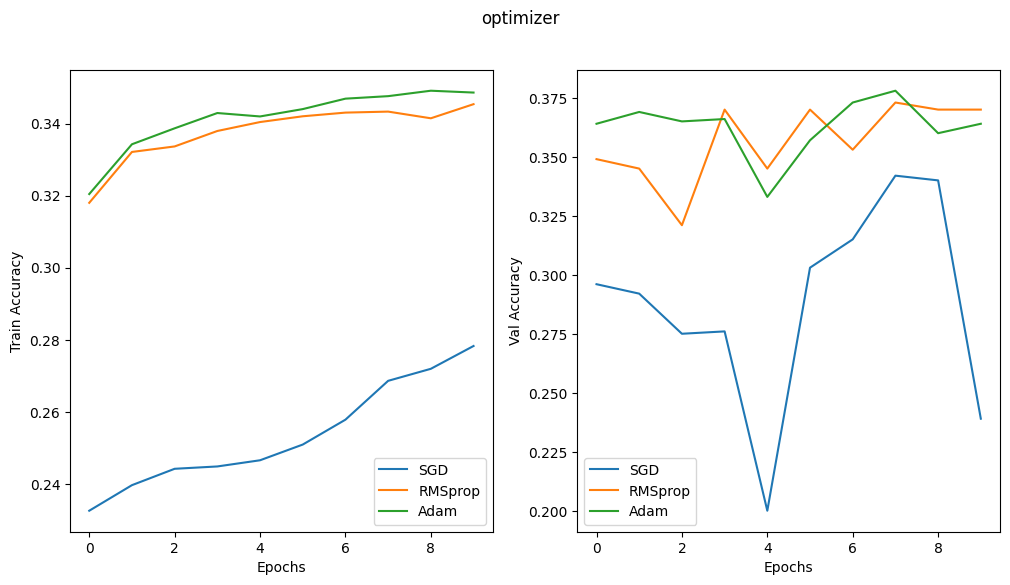

In [ ]:
column_name = 'optimizer'
plot_accuracy(column_name, df)

## Mini-Batch

Mini-Batch seems to have a significant effect on the learning. We see that during training the mini-batch of size 2 performs worse than 64, which can be attributed to the fact that the mean and variance estimates for mini-batch were worse which was expected.

Surprisingly the batch_size of 16 fared worse than 2 which could be due to the fact that the former gets more number of update per epoch. But we see that in the validation side they perform quite similar.

We also experimented with Batch-Gradient Descent and we got very low accuracy of 2% which was expected as that effectively turns the number of updates to only 10!


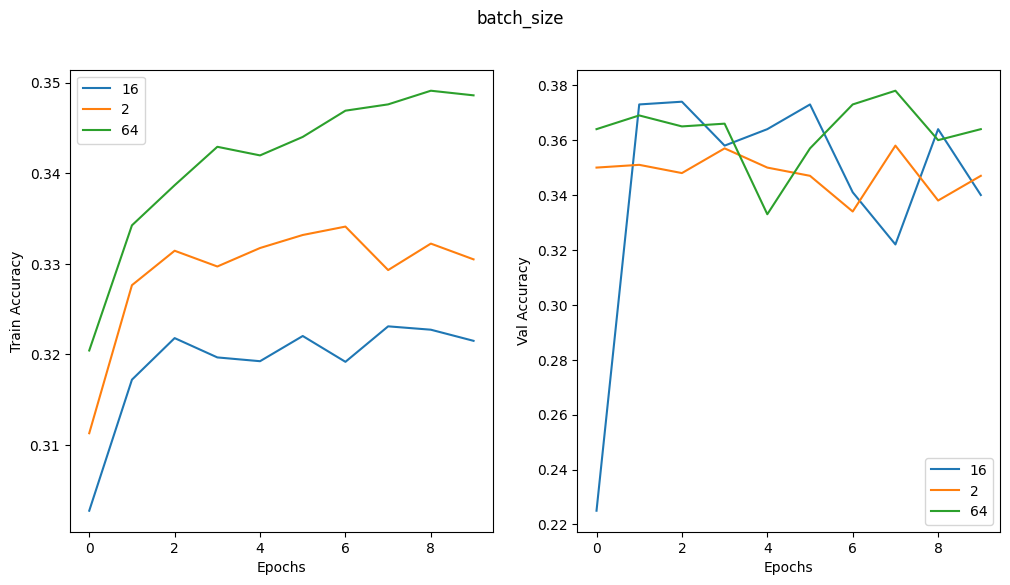

In [ ]:
column_name = 'batch_size'
plot_accuracy(column_name, df)

## Batch Normalization

We see that batch normalization didnt make much of a difference in training, but in validation we can see that the run where batch normalization was used yeild a more stable validation accuracy. We suspect when batch normalization is not applied the weights outputs becomes too sensitve to weight changesm whereas with batch noramlization the output is less sesitive to weight pertubations and is hence better.

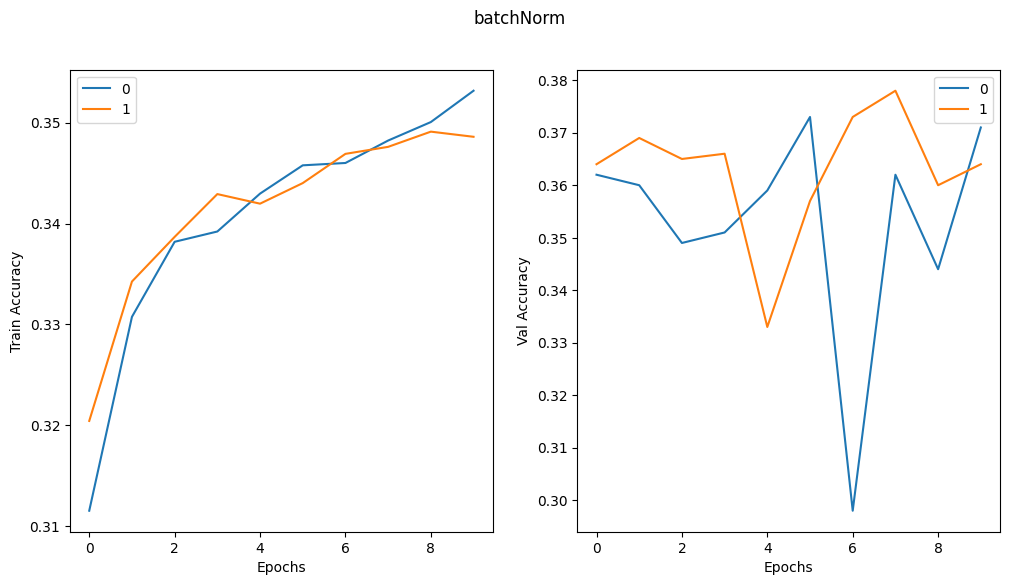

In [ ]:
column_name = 'batchNorm'
plot_accuracy(column_name, df)

## Dropout
Choosing a nonzero dropout value seems to cause slightly better overall performance toward the later stages in the validation set, which makes sense as the technique combats overfitting. However, if we compare the best accuracies of all these runs they only deviate by a small margin.

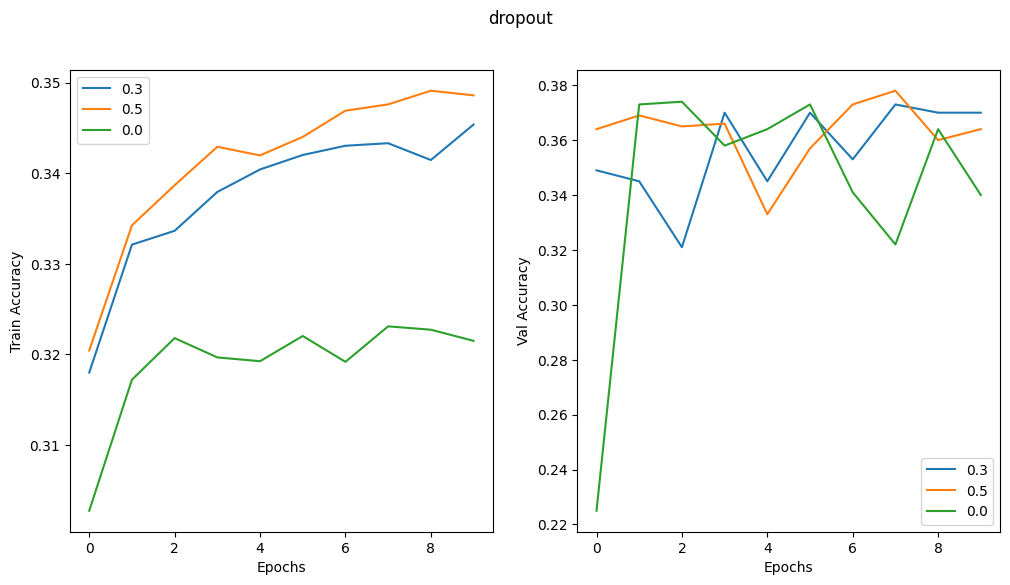

In [ ]:
column_name = 'dropout'
plot_accuracy(column_name, df)

## Hidden Size

From the graphs we can see that hidden size didnt really have much of an affect on accuracy on both training and testing. The best models for each achieves nearly the same accuracy.

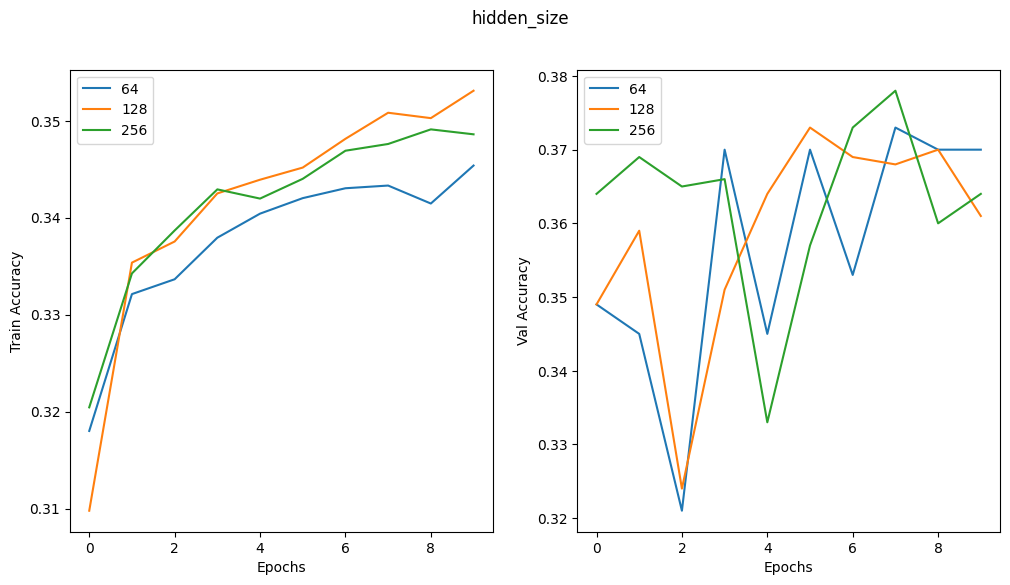

In [ ]:
column_name = 'hidden_size'
plot_accuracy(column_name, df)

## Activation

The choice of activation was somewhat important. Sigmoid and ReLU tended to outperform Tanh in the training, but all 3 performed more similarly with the validation set. The Sigmoid activation seemed to perform best overall.

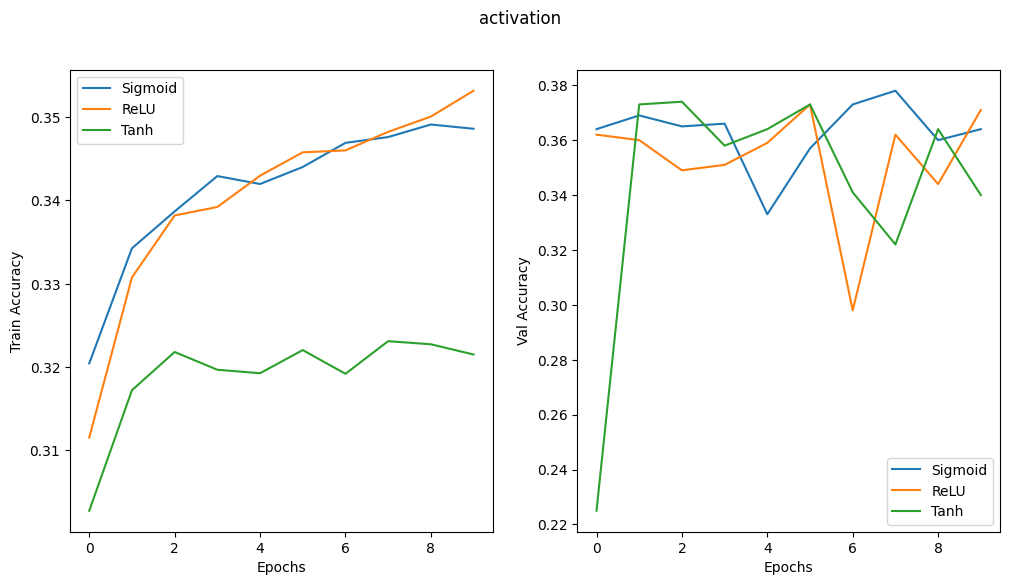

In [ ]:
column_name = 'activation'
plot_accuracy(column_name, df)

# Wandb Correlation Plot

1. As can be seen here, the optimizer choice is clearly the most important choice, with Adam and RMSprop performing much better than SGD.

2. We see that sigmoid was preferred over other activations, but surprisibly the best performing models used ReLU.

3. We also see that batch size has a positive correlation with accuracy which makes sense as we are using batch noramlization.

4. Learning rate has a negative correlation with accuracy, which can be attributed to the fact that higher learning rate will lead to early overfitting.

5. Lastly hidden size has a positive correlation with the accuracy which was to be expected as increasing hidden size increases the representaion power.

![image.png](https://drive.google.com/uc?id=1DJB2c33ZNdrBbP-bg7kqQxd0twR6xjoI)